In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as smp
from matplotlib.backends.backend_pdf import PdfPages
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

In [259]:
# Custom function for creating grouped barplots of the variables of interest and save the output

def custom_barplots(dataset, # dataframe
                    groupping, # string
                    variables_of_interest, # list of string(s)
                    title_of_output='example.pdf', # string
                    barwidth=0.5, myspacingy=0.09, myspacingx=8, myfontsize=17,
                    high_risk_option = 'no', interactivity = 'no'):
    
    pdf = PdfPages(title_of_output)
    figures = []
    
    row = 0
    
    for variable in variables_of_interest:

        temp = dataset.copy()

        # Group according to the features of interest and calculate the % of answer types for the main target feature
        temp = temp.groupby([groupping, variable])[variable].agg(['count'])
        temp['total'] = temp.groupby(groupping)['count'].transform('sum')
        lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
        temp['CI_prop_upper'] = upper
        temp['CI_prop_lower'] = lower
        temp[variable + ' (%)'] = temp['count'] / temp['total'] * 100
        temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
        temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
        temp['abs_err'] = temp[variable + ' (%)'] - temp['CI_perc_lower']
        temp.reset_index(inplace=True) # To 'undo' the grouping
        temp = temp.round(1)
        temp
        
        high_risk_option_chosen = high_risk_option
        if high_risk_option_chosen == 'yes':
            high_risk_answer = question_risk_aswers.loc[row, 'high_risk_answer']
            temp = temp[temp[variable] == high_risk_answer]
            row += 1
    
        # Recode the answers of those variables we want to use to stratify the population
        answers_to_rename = [variable]
        temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict)

        abs_err = temp.pivot(index=variable, columns=groupping, values='abs_err')

        g = temp.pivot(index=variable, columns=groupping, values=variable+' (%)')\
        .plot(kind='barh', xerr=abs_err, width=barwidth, figsize=(3,10))
        for item in ([g.title, g.xaxis.label, g.yaxis.label] + g.get_xticklabels() + g.get_yticklabels()):
            item.set_fontsize(20)
        plt.title(questions_dict.get(variable), x =0,  fontsize = 20)
        plt.xlabel(variable + ' (%)')
        plt.ylabel('')
        plt.xlim(0, max(temp[variable +' (%)'] + 15))
        g.legend(loc='center left', bbox_to_anchor=(1.5, 0.75), fontsize=16)
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        g.spines['left'].set_visible(False)

        # To plot the % number
        for p in g.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            g.annotate('{:}%'.format(width), (x + width + myspacingx, y + myspacingy), fontsize = myfontsize)
            # play with fontsize, depending on graph

        #plt.show()
        
        figures += [g.figure]
    
    if interactivity == 'no':
        for figure in figures:
            pdf.savefig(figure, bbox_inches='tight') # output file is saved in the same folder as this notebook
        pdf.close()


####################################################################

# Custom functions for cleating temporal line plots

# The following function specifies the % number on top and the count number below.
def custom_lineplots(x,y,z, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(y.values[i]) + '%', xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')
    for i in range(len(x)):
        ax.annotate('n=' + str(z.values[i]), xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,-10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')

# Wrapper function for plt.errorbar
def errorbar(x, y, low, high,  color, **kws):
    plt.errorbar(x, y, (y - low, high - y), color=color)

# Complete lineplot function
def custom_lineplots_complete(dataset, # dataframe
                              variables_of_interest, # list of string(s)
                              title_of_output): # string
    
    pdf = PdfPages(title_of_output)
    figures = []

    for variable in variables_of_interest:
    
        temp = dataset[[variable] + ['country_dv', 'surveyyear']]

        # Group according to the features of interest and calculate the % of answer types for the main target feature
        temp = temp.groupby(['country_dv','surveyyear', variable])[variable].agg(['count'])
        temp['total'] = temp.groupby(['country_dv','surveyyear'])['count'].transform('sum')
        lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
        temp['CI_prop_upper'] = upper
        temp['CI_prop_lower'] = lower
        temp[variable + ' (%)'] = temp['count'] / temp['total'] * 100
        temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
        temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
        temp.reset_index(inplace=True) # To 'undo' the grouping
        temp = temp.round(1)

        # Recode the answers of those variables we want to use to stratify the population
        answers_to_rename = ['country_dv', variable, 'surveyyear']
        temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict) # pandas 1.0.3 (or newer) needed for nested replace

        # Plot features of interest from the created 'temp' subset
        g = sns.FacetGrid(temp, col='country_dv', hue=variable, height=4, aspect=1) 
        g.map(errorbar, 'surveyyear', variable + ' (%)', 'CI_perc_lower', 'CI_perc_upper')
        g = (g.map(custom_lineplots, 'surveyyear', variable + ' (%)', 'count')
             .add_legend())
        plt.xlim(2009, 2019)
        g.set_titles('{col_name}', pad = 25)
        plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True, labelleft=True)
        plt.figtext(.5,.9, questions_dict.get(variable), fontsize=12, ha='center')

        figures += [g.fig]

    for figure in figures:
        pdf.savefig(figure)
    pdf.close()

In [ ]:
# DATA ANALYSIS STARTS HERE

In [344]:
# Dictionary to recode values (as on survey dataset)

survey_guide_path = '/Users/garcial/My_documents/Personal documents/S2DS_course/FSA_project/Data/food survey/withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'
#survey_guide_path = 'insert_your_own_path/withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'

# Create a dictionary of question names
questions_dict = pd.read_excel(survey_guide_path, 'Variables')
questions_dict = pd.Series(questions_dict.Label.values, index=questions_dict.Variable).to_dict()

# Create a nested dictionary of answer names
answers_dict = pd.read_excel(survey_guide_path, 'Values')
answers_dict['Label'] = (answers_dict['Label']
                         .replace({'Wave 1':2010, 'Wave 2':2012, 'Wave 3':2014, 'Wave 4':2016, 'Wave 5':2018})
                         .replace({'Married/Civil Partnership/Living with Partner':'Married/Partnership'})
                         .replace({'Single/Widowed/Divorced/Separated/Other':'Single/Other'}))
answers_dict = answers_dict.fillna(method='ffill')
answers_dict = answers_dict.groupby('Variable')[['Vlue', 'Label']].apply(lambda g: dict(g.values)).to_dict()
answers_dict['wimd_2014_quintile'] = {1: 1, 2: 2, # 1 is most deprived
                                      3: 3, 4: 4, 5: 5, # 5 is least deprived
                                      -8: "Don't know", -1:'Not applicable'}
answers_dict['hhdinc'] = {1: '£10,399 or less', 2: '£10,400 - £25,999', 3: '£26,000 - £51,999', 4:'£52,000 or more',
                          -9:'Refused', -8: "Don't know", -1:'Not applicable'}

# can also host data online, see:
# questions_dict_path = 'https://raw.githubusercontent.com/lorena-gp/food-standards-agency/master/survey_guide_variables.csv'
# answers_dict_path = 'https://raw.githubusercontent.com/lorena-gp/food-standards-agency/master/survey_guide_values.csv'

In [346]:
answers_dict

{'C1': {-9: 'Refused',
  -8: "Don't know",
  -1: 'Not applicable',
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  98: "Don't know"},
 'C2': {-9: 'Refused',
  -8: "Don't know",
  -1: 'Not applicable',
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  98: "Don't know"},
 'C3': {-9: 'Refused',
  -8: "Don't know",
  -1: 'Not applicable',
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  98: "Don't know"},
 'C4': {-9: 'Refused',
  -8: "Don't know",
  -1: 'Not applicable',
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  98: "Don't know"},
 'C5': {-9: 'Refused',
  -8: "Don't know",
  -1: 'Not applicable',
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  98: "Don't know"},
 'C6': {-9: 'Refused',
  -8: "Don't know",
  -1: 'Not applicable',
  0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5

In [96]:
# Load Food and You survey dataset

survey_path = '/Users/garcial/My_documents/Personal documents/S2DS_course/FSA_project/Data/food survey/Food+and+You+Waves+1-5+Data (3).csv'
#survey_path = 'insert_your_own_path/Food+and+You+Waves+1-5+Data (3).csv'
survey_full_dataset = pd.read_csv(survey_path)
survey_full_dataset = pd.DataFrame(survey_full_dataset)

# Encode 'Not applicable', 'Refused' and 'Don't know' as NaN
survey_full_dataset = survey_full_dataset.replace([-9, -8, -1, 98], np.nan)
cols_5_NaN = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
              'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
survey_full_dataset[cols_5_NaN] = survey_full_dataset[cols_5_NaN].replace([5], np.nan)

survey_full_dataset['age_dv_grouped'] = (survey_full_dataset['age_dv']
                                         .replace({1:'A', 2:'B', 3:'B', 4:'B', 5:'C', 6:'C', 7:'C'})
                                         .replace({'A':'16-24', 'B':'25-54', 'C':'55+'}))
# can also host data online, see:
# survey_path = 'https://raw.githubusercontent.com/lorena-gp/food-standards-agency/master/survey.csv'

In [4]:
# DEMOGRAPHIC ANALYSIS OF THE F&Y SURVEY

In [4]:
# Define demographic variables of interest
demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 'workstat2',
                         'Q6_1', 'age_dv_grouped'] # These match the census

In [5]:
# Join relevant survey data with the census data in a single dataframe

demographics_survey_and_census = survey_full_dataset[survey_full_dataset.country_dv.eq(2)] # Select Wales
demographics_survey_and_census = demographics_survey_and_census[demographic_variables]
demographics_survey_and_census['source'] = 'survey'

# Read prepared census data
census_path = '/Users/garcial/My_documents/Personal documents/S2DS_course/FSA_project/Data/census_2011_Wales_prepared.csv'
#census_path = 'insert_your_own_path/census_2011_Wales_prepared.csv'
census = pd.read_csv(census_path)
census = pd.DataFrame(census)
census['source'] = 'census'

demographics_survey_and_census = pd.concat([demographics_survey_and_census, census])

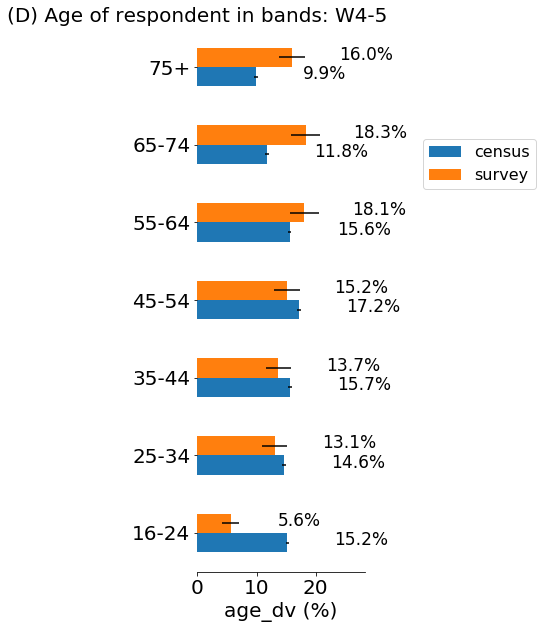

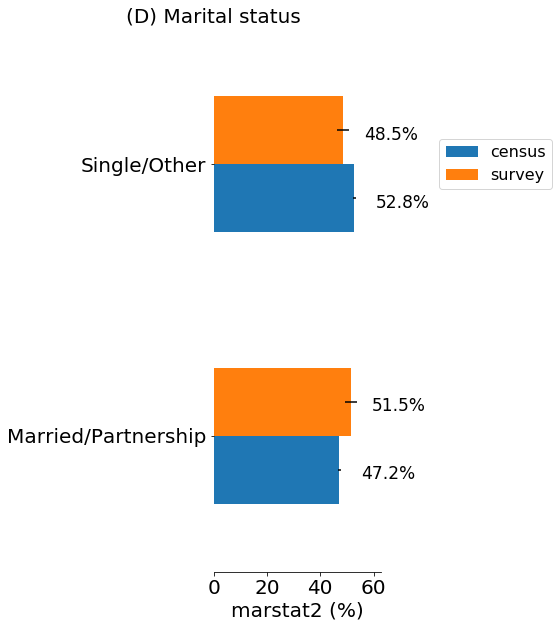

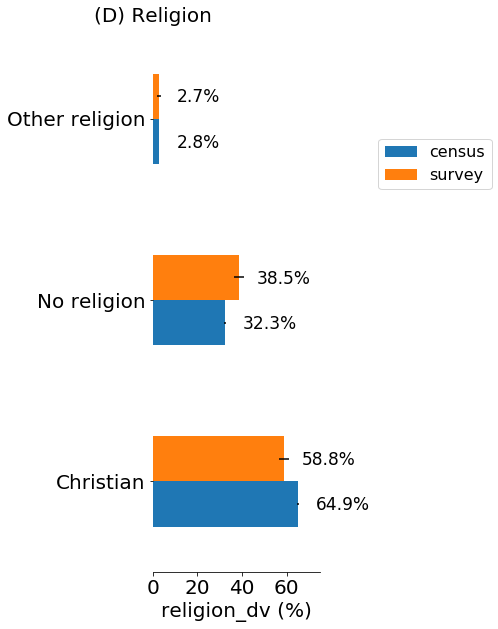

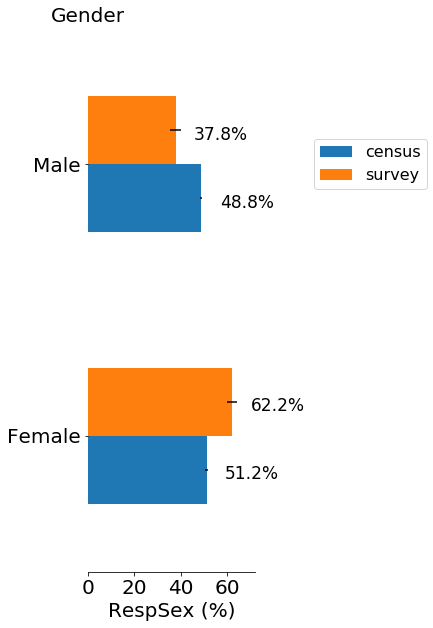

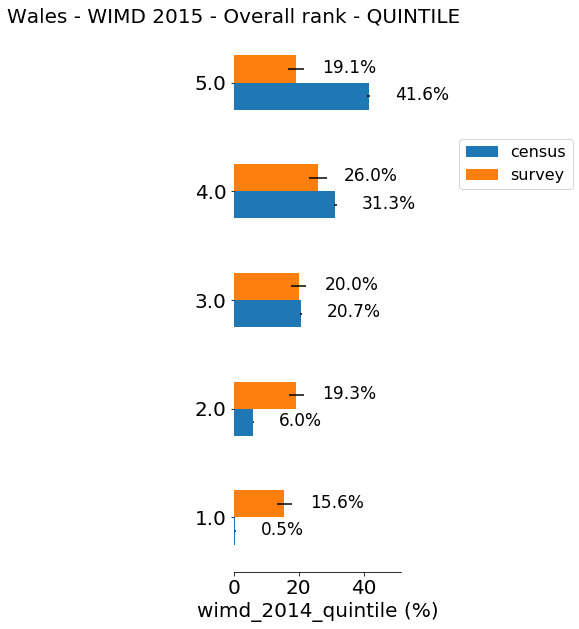

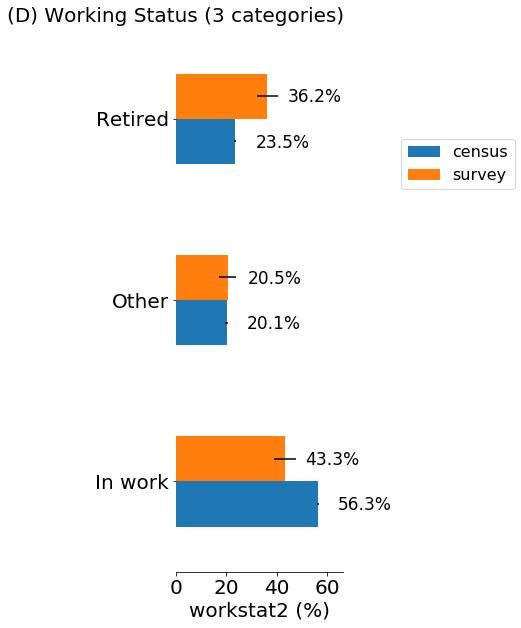

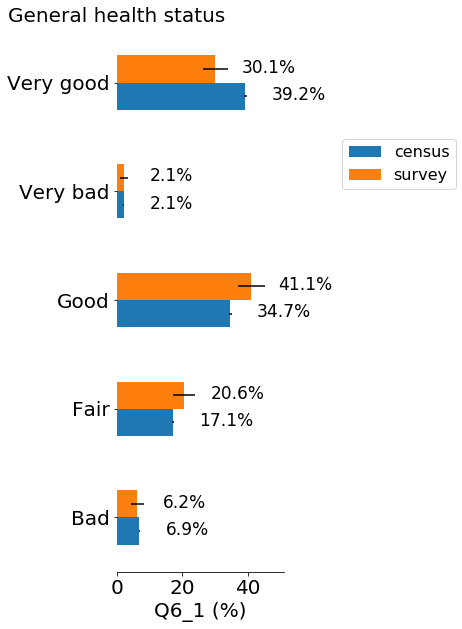

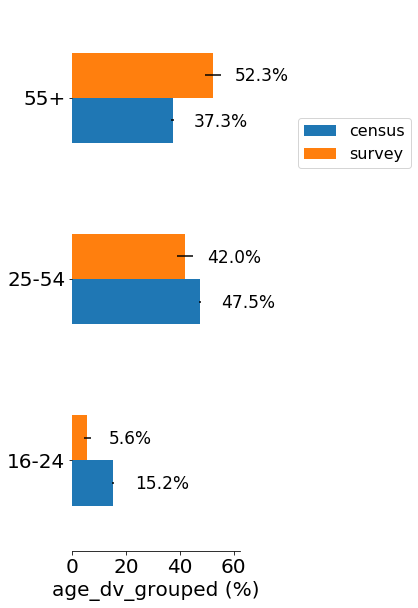

In [140]:
# Plotting demographic variables survey vs census

custom_barplots(demographics_survey_and_census,
                'source',
                demographic_variables,
                'survey_vs_census_combined-demographics.pdf')

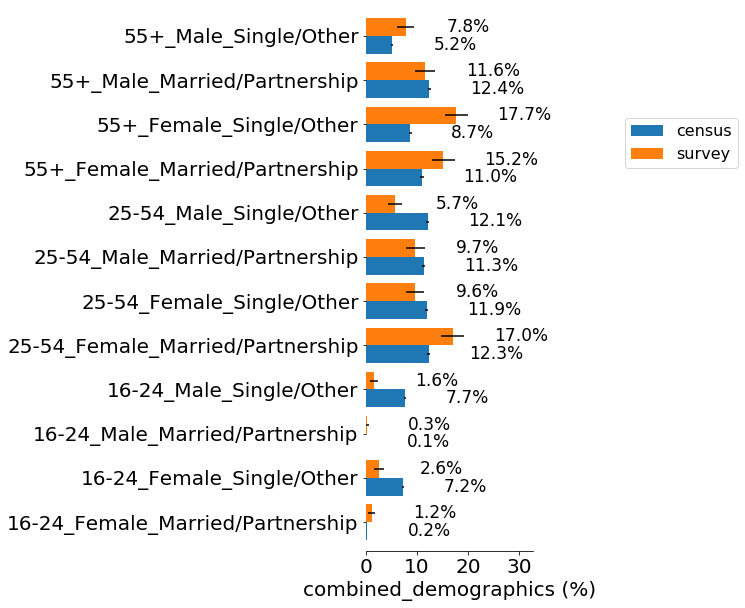

In [260]:
# Combined demographic representation of all F&Y surveys in Wales, versus census 2011

demographics_survey_and_census[demographic_variables] = demographics_survey_and_census[demographic_variables].replace(answers_dict)

demographics_survey_and_census['combined_demographics'] = (demographics_survey_and_census['age_dv_grouped'] + '_' +
                                                           demographics_survey_and_census['RespSex'] + '_' +
                                                           demographics_survey_and_census['marstat2'])

custom_barplots(demographics_survey_and_census,
                'source',
                ['combined_demographics'],
                'survey_vs_census_combined-demographics.pdf',
                barwidth=0.8)

In [332]:
# More extensive list of demographic variables, for use with survey data only

demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 'workstat2',
                         'Q6_1', 'age_dv_grouped', 'UrbanRuralInd', 'bhhsize2', 'hhdinc',
                         'below6', 'below16']

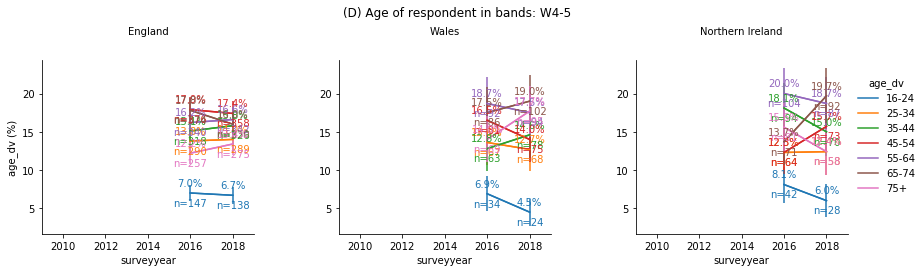

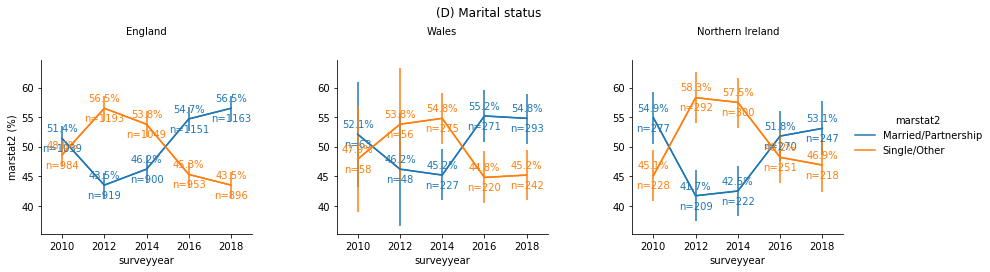

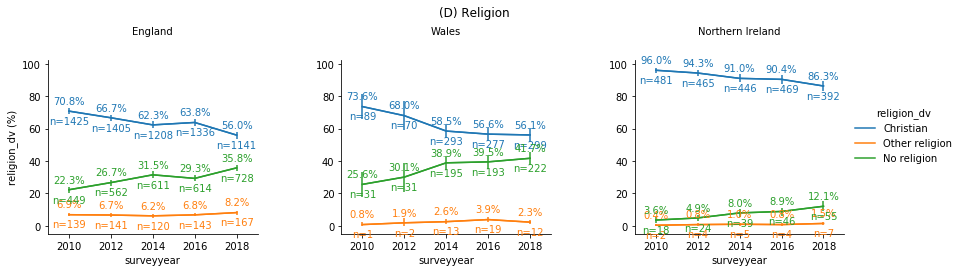

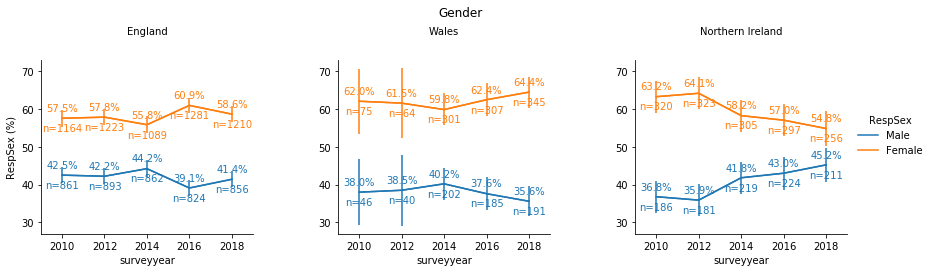

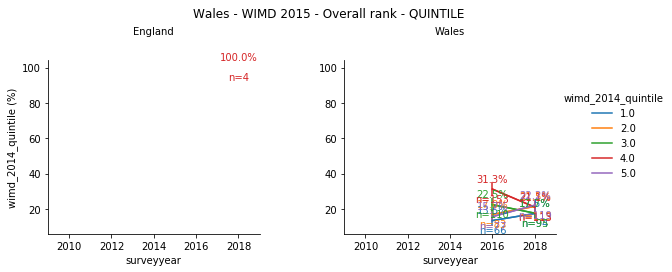

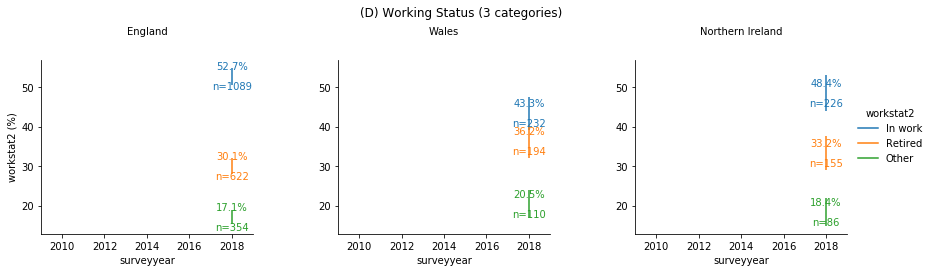

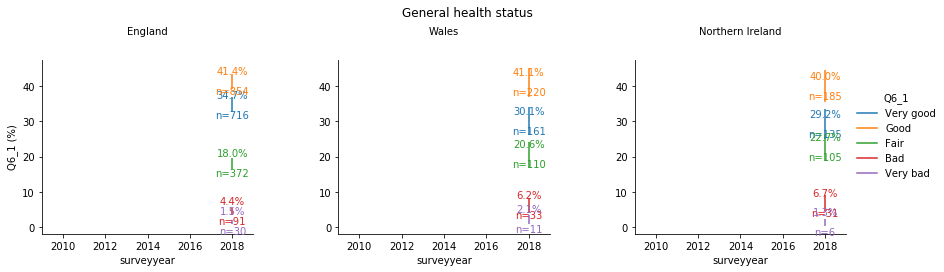

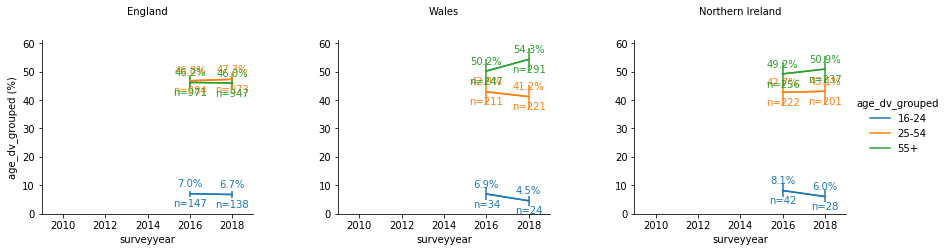

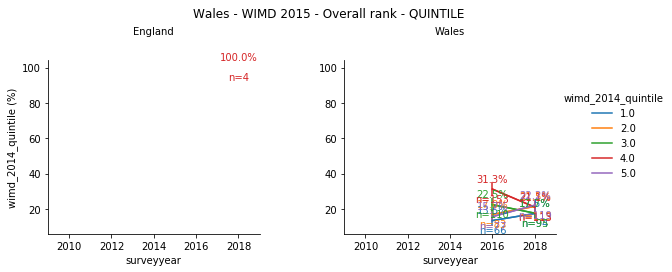

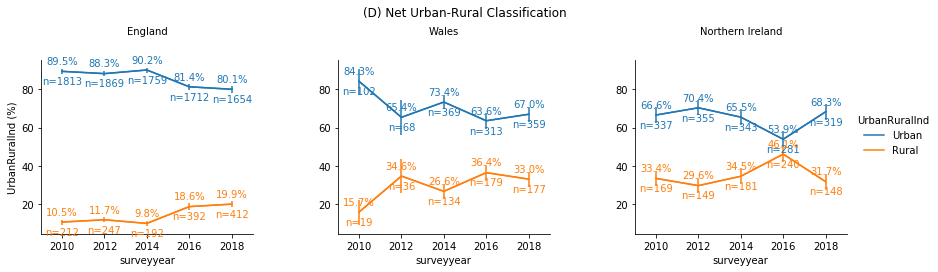

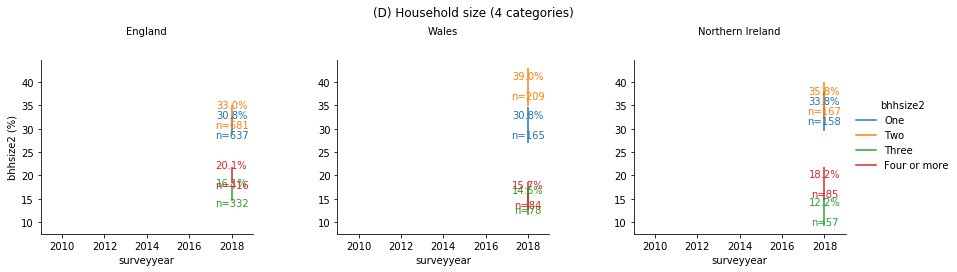

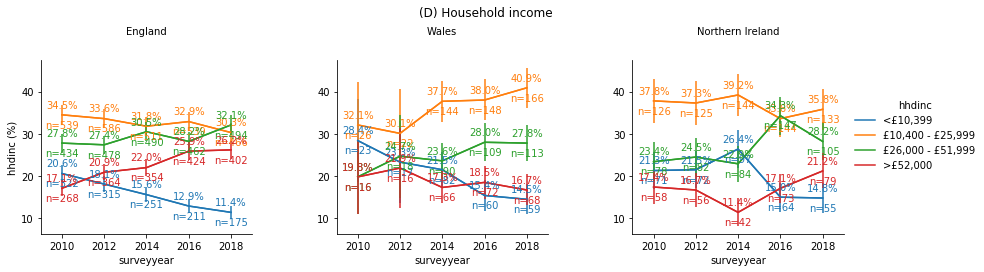

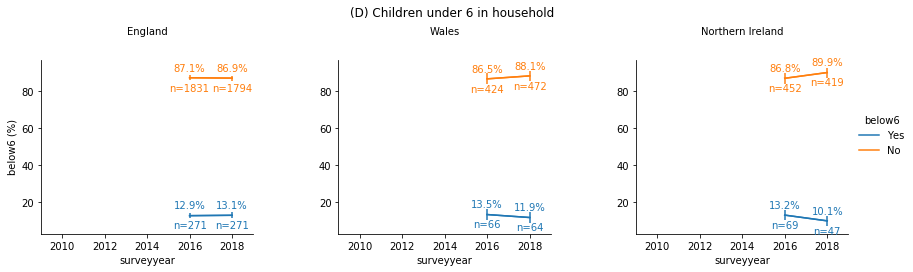

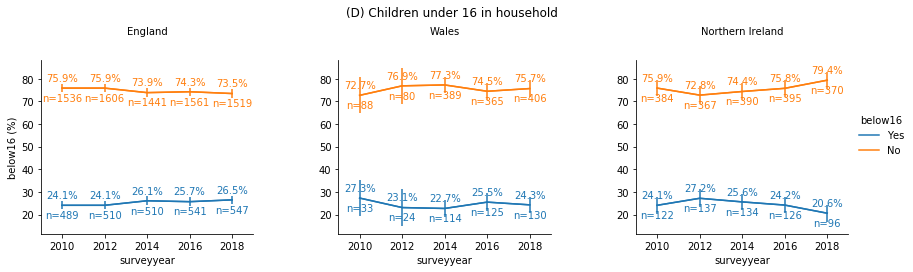

In [327]:
# Temporal analysis of F&Y demographics per country

custom_lineplots_complete(survey_full_dataset,
                          demographic_variables,
                          'survey_demographics_time.pdf')

In [ ]:
# FOOD RISK ANALYSIS OF THE F&Y SURVEY

In [328]:
# Define questions of interest
questions_of_interest = ['bpoison', 'Q4_1_5_comb', 'eatoutev', 'q4_1_6', 'Q4_1_5_comb', 'Q4_19b', 'fdsecst',
                         'sanspray', 'Q4_26b', 'q4_1_8a', 'q4_1_11', 'dq4_1bc', 'Q4_143', 'safemeat10',
                         'Q4_2610', 'q4_27_4_slice', 'Q4_27c', 'Q4_28b8', 'q2_14s10a_dv', 'q2_14su8b_dv',
                         'q2_14su7a_dv', 'q2_14s13_dv', 'EatOut1', 'EatOut2', 'EatOut3']

# Define high risk answers to questions of interest (in same order)
high_risk_answers = [1,1,1,4,4,4,4,1,1,1,1,2,1,1,1,5,2,1,4,4,4,4,1,1,1]
question_risk_aswers = pd.DataFrame(
    {'question': questions_of_interest,
     'high_risk_answer': high_risk_answers
    })
#q2_14s10a_dv, q2_14su8b_dv, q2_14su7a_dv, q2_14s13_dv: multiple high_risk answers: 1-7
#EatOut3 problem is that the question with its answers is doubleD!!

In [347]:
# To consider only the survey answers from wave 4 and 5 only:
waves = [4,5]
survey_subpopulation = survey_full_dataset.loc[survey_full_dataset['surveyyear'].isin(waves)]
survey_subpopulation[demographic_variables] = survey_subpopulation[demographic_variables].replace(answers_dict)

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


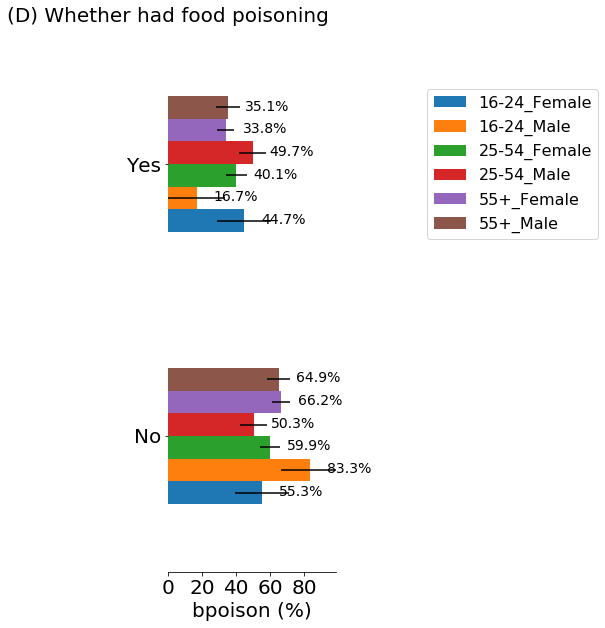

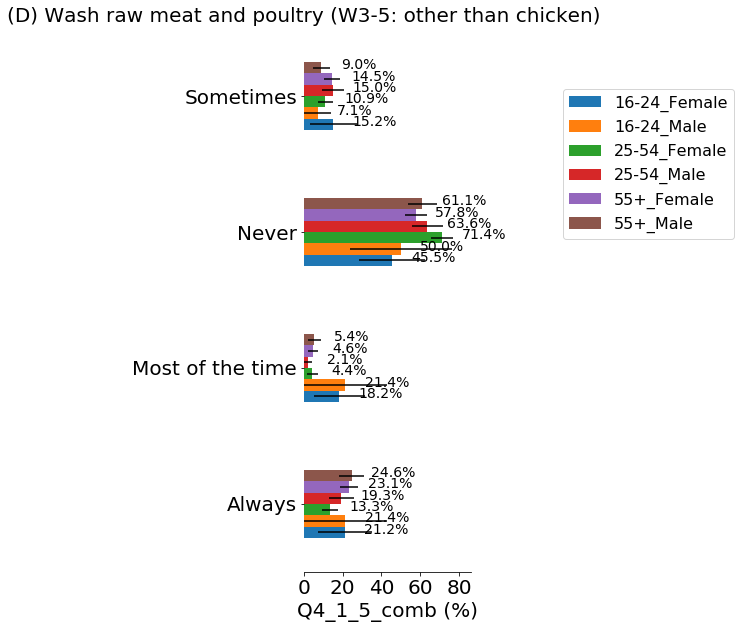

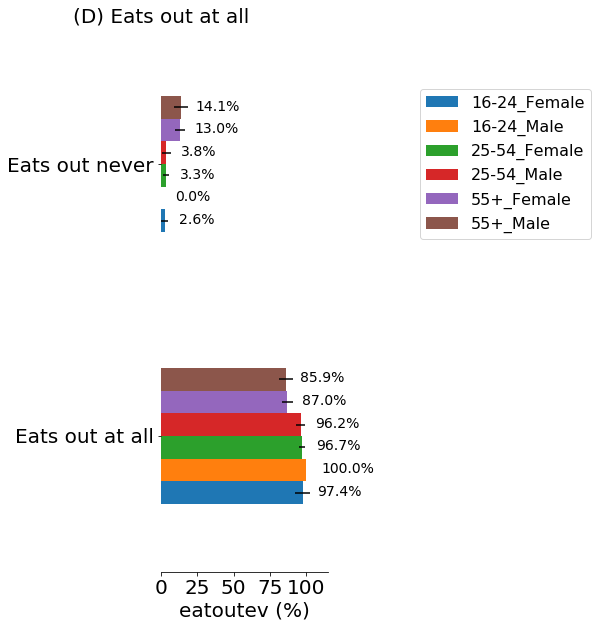

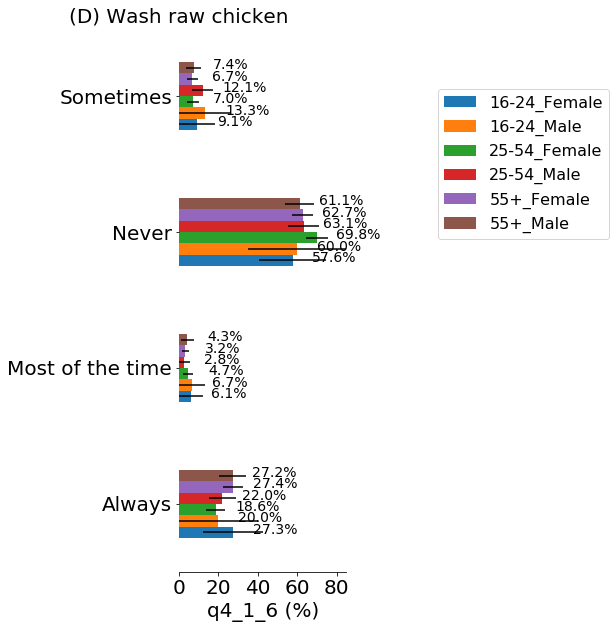

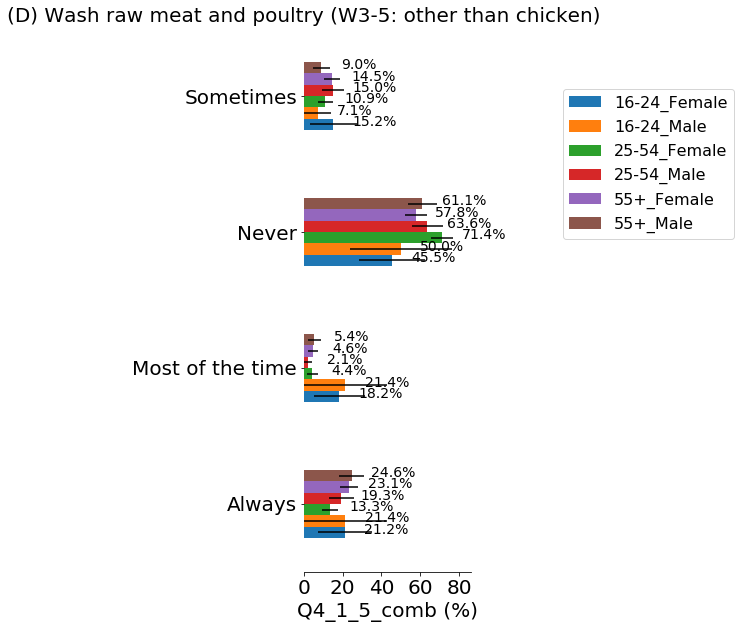

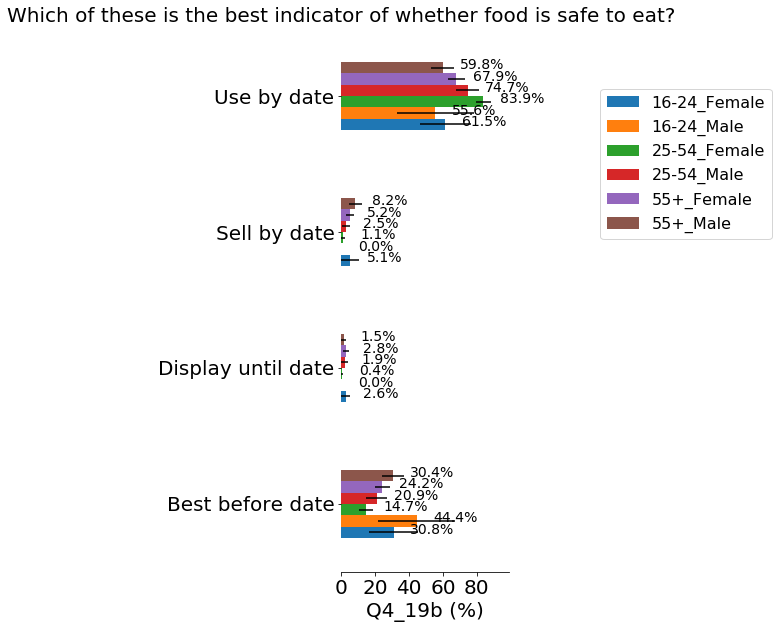

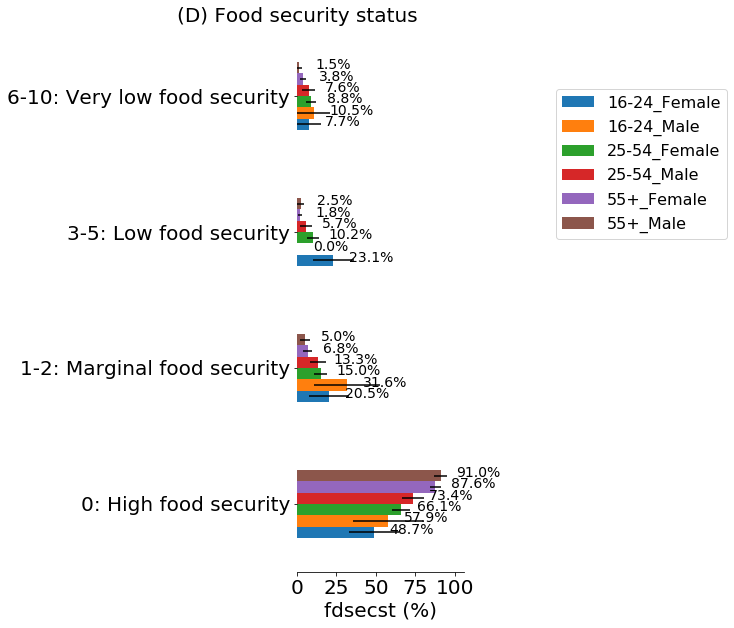

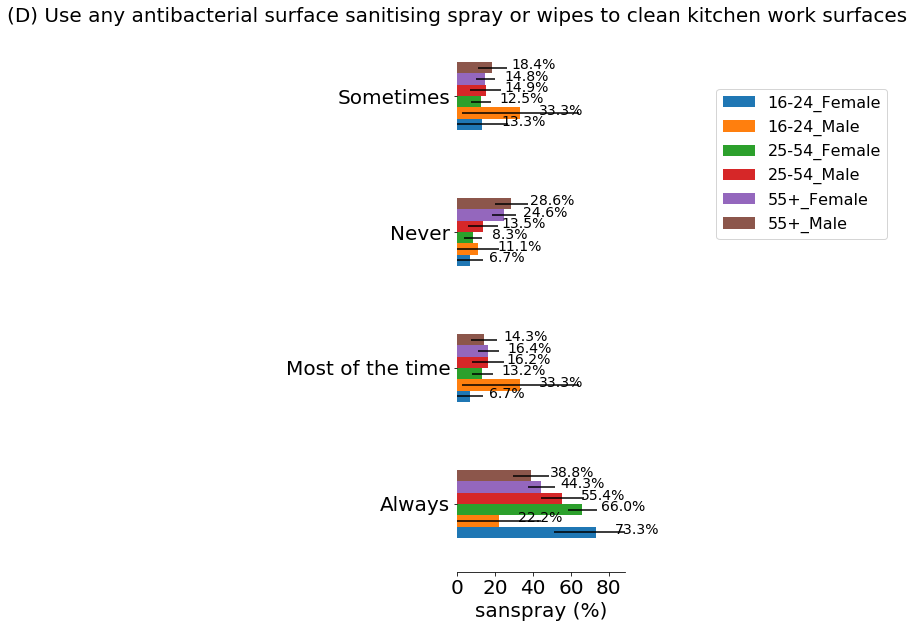

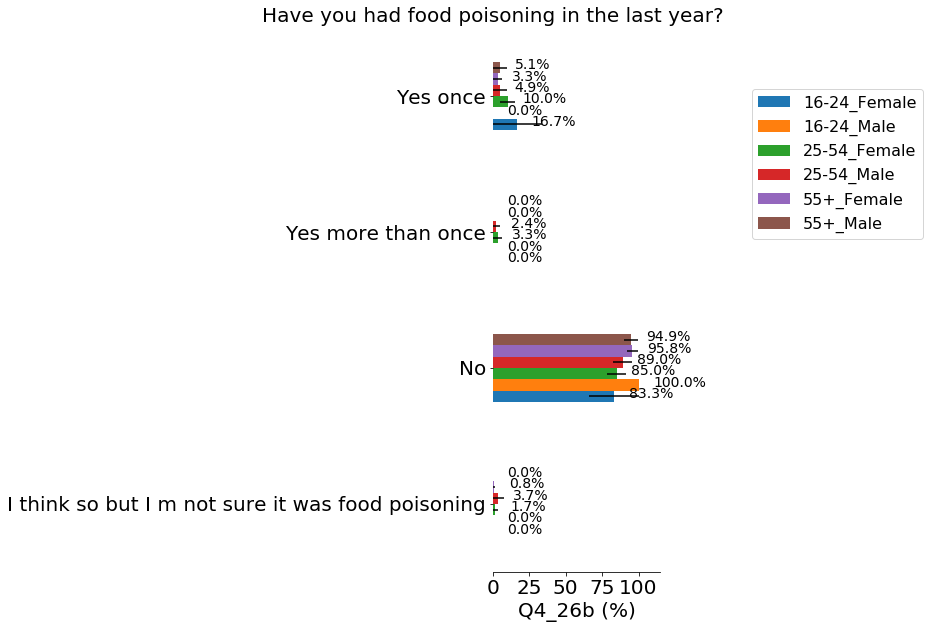

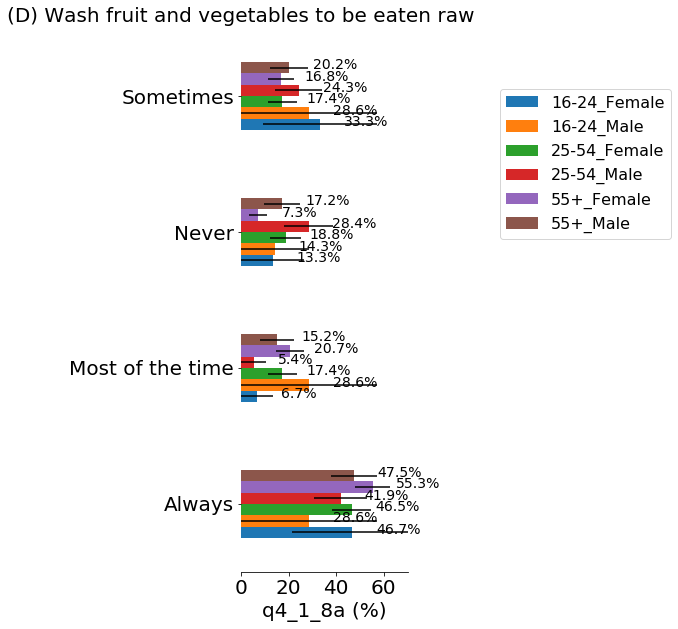

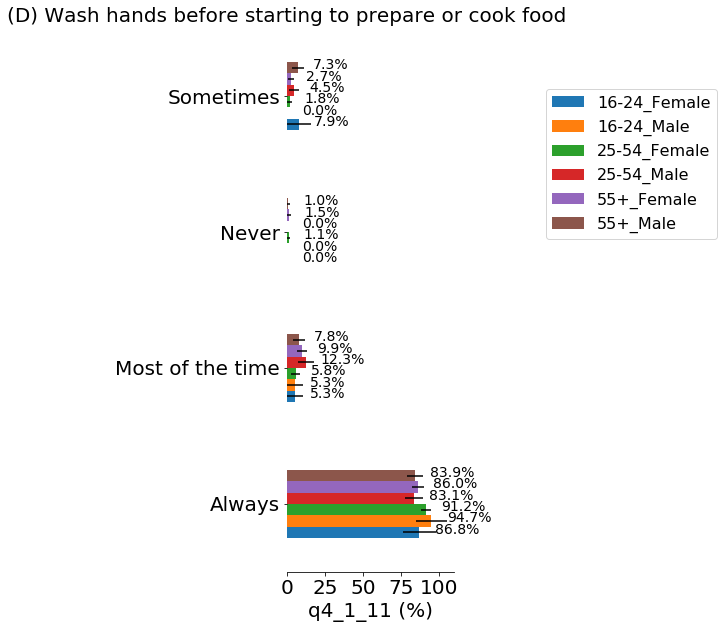

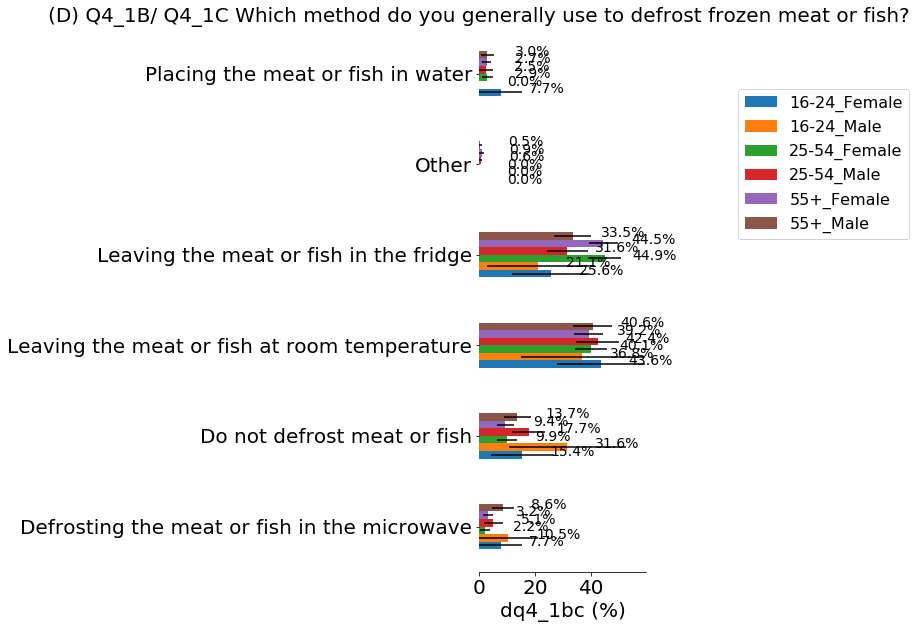

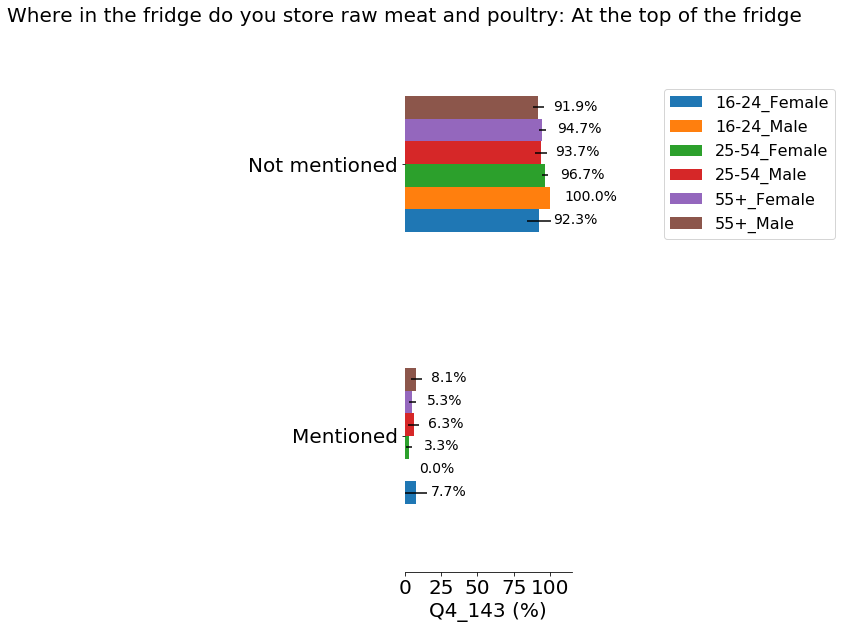

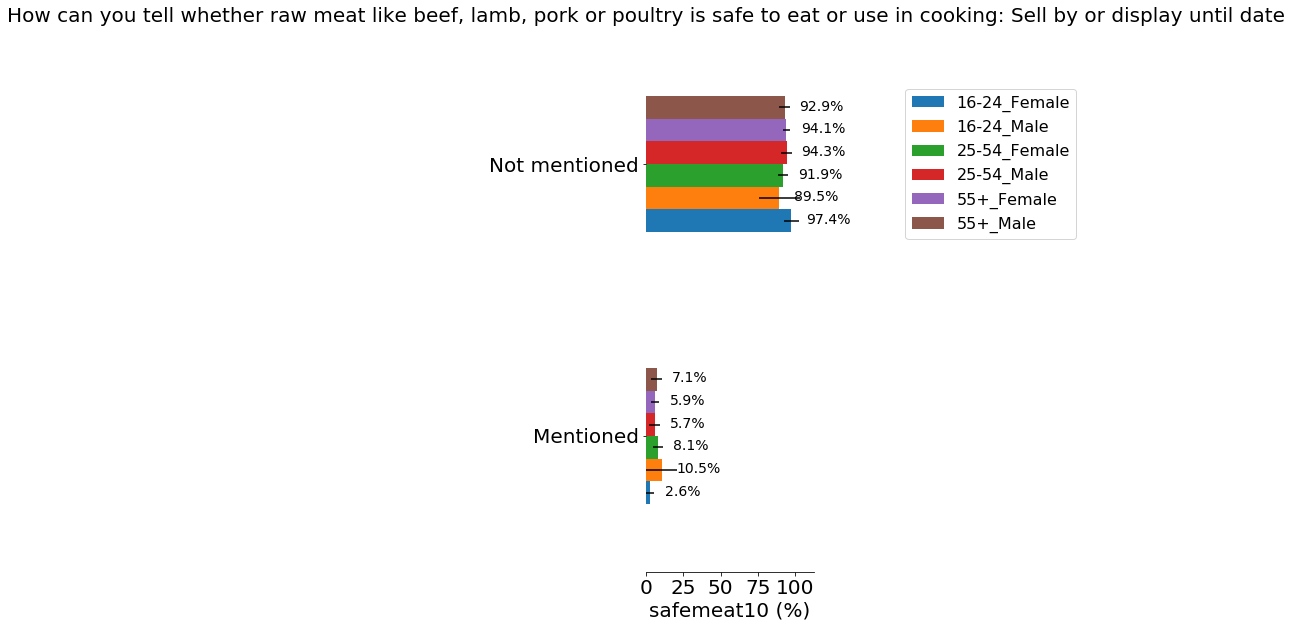

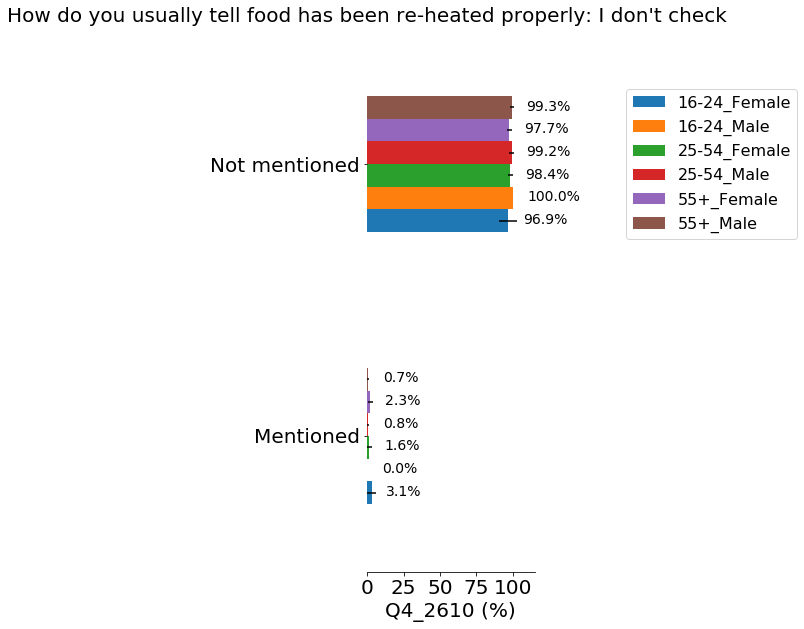

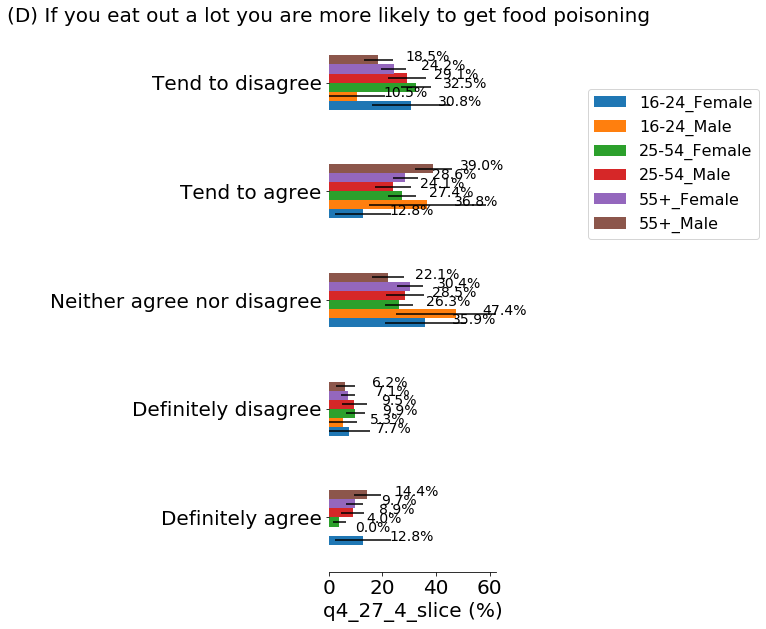

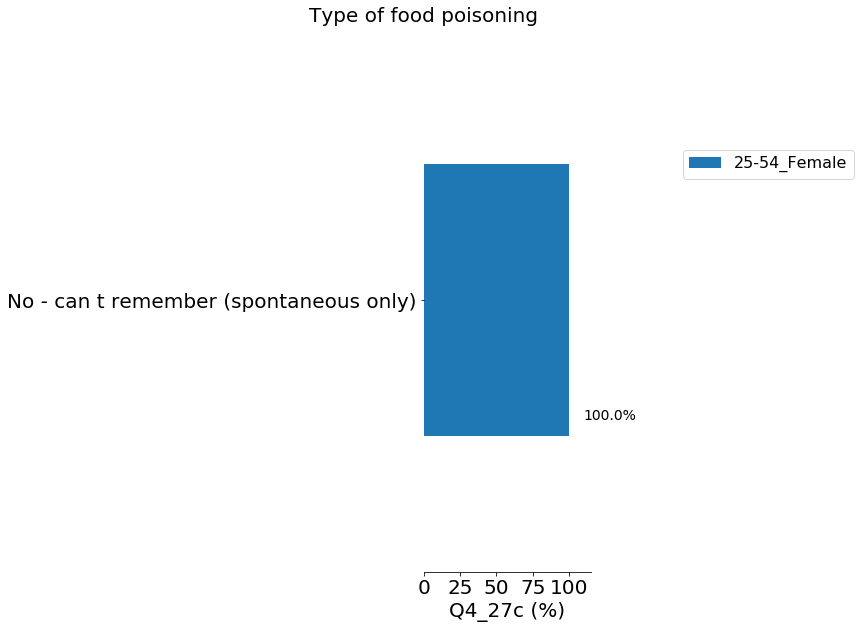

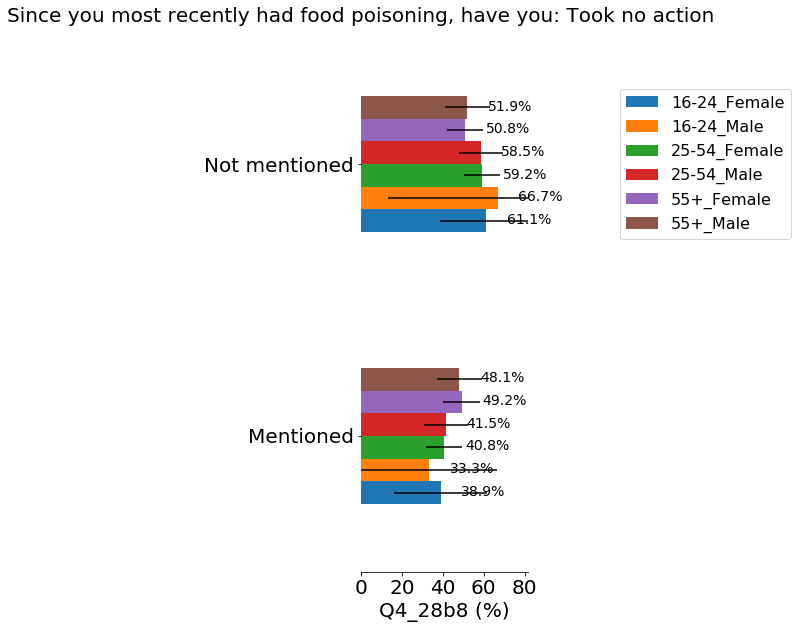

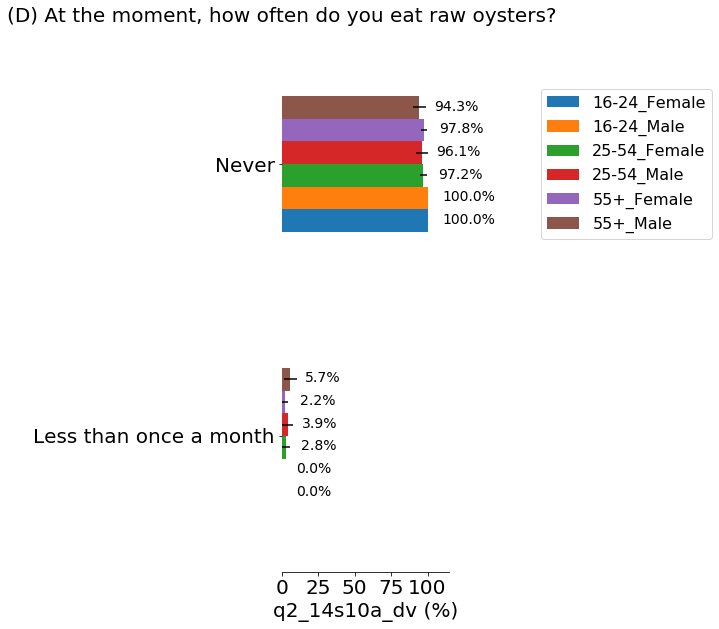

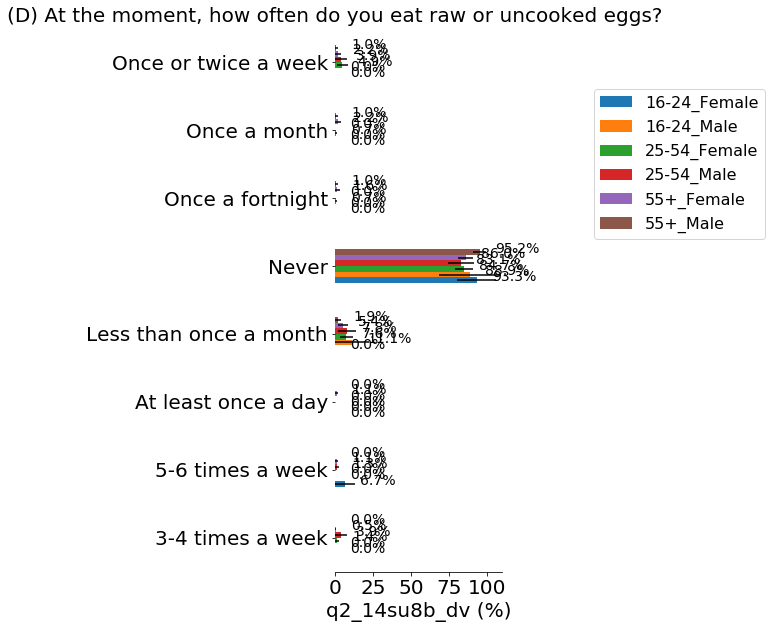

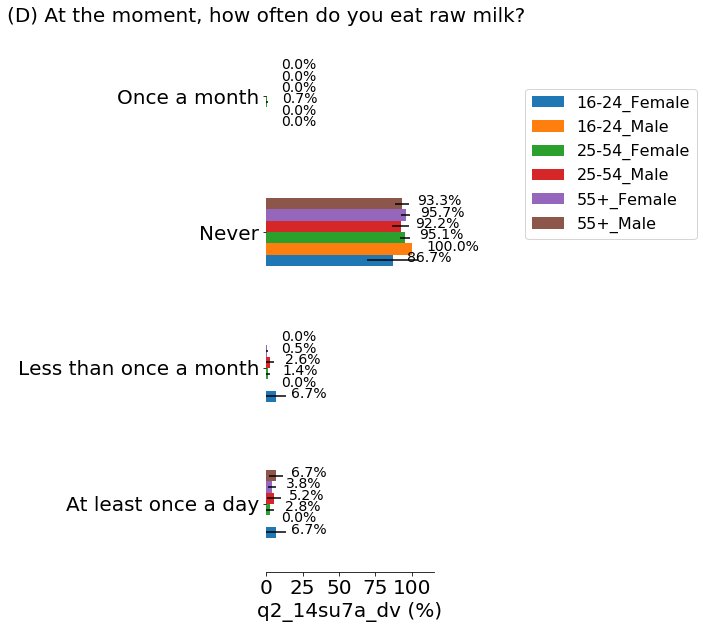

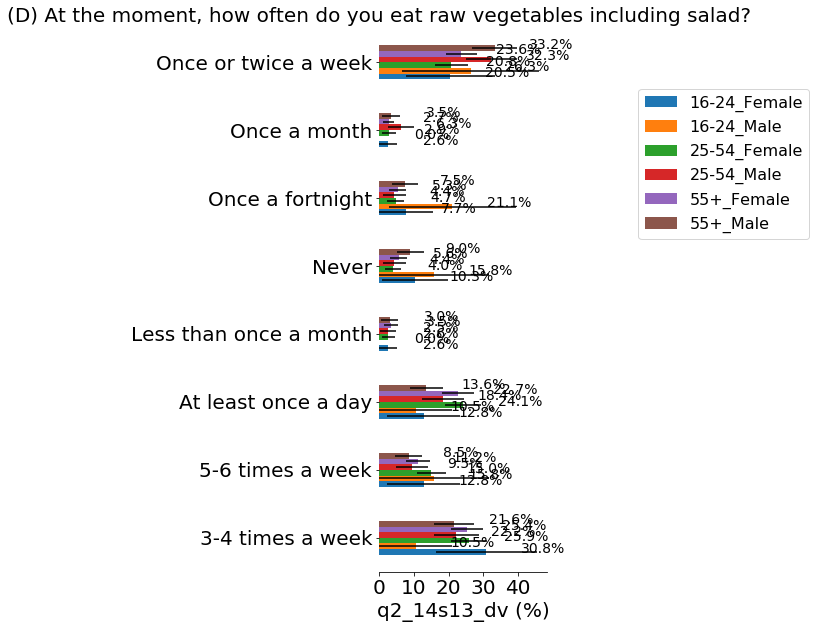

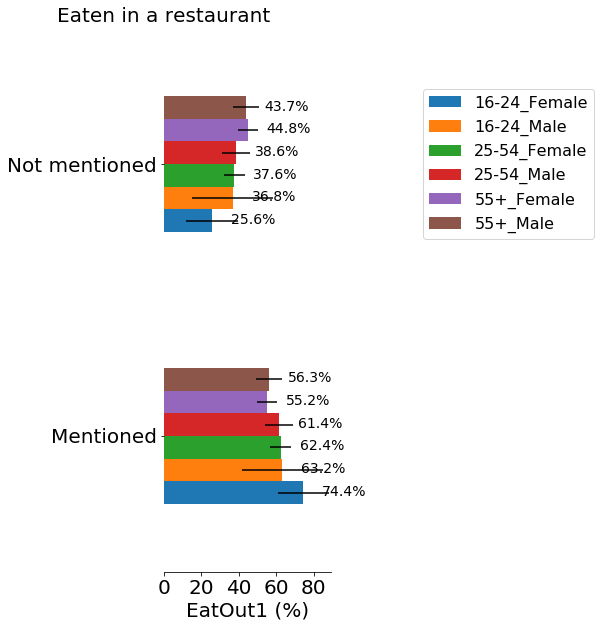

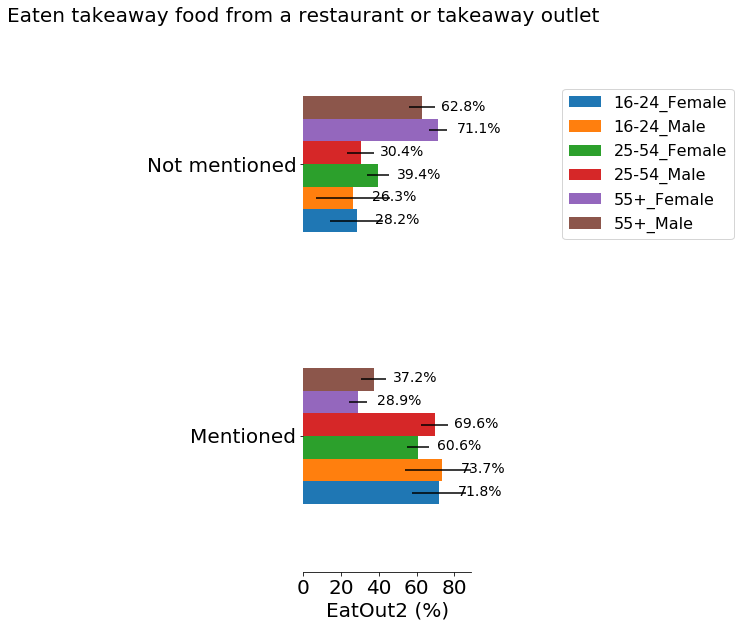

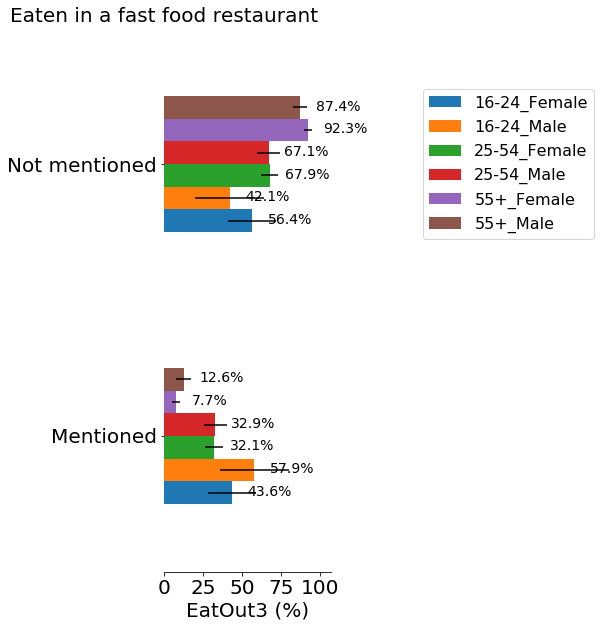

In [265]:
# Plot food risks associated to desired subpopulation groups for specified relevant questions:
# All answers plotted   

custom_barplots(survey_subpopulation[survey_subpopulation.country_dv.eq(2)],
                'combined_demographics',
                questions_of_interest,
                'foodBehaviour_byDemographics.pdf',
                myspacingy=0.03, myspacingx=10, myfontsize=14)


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


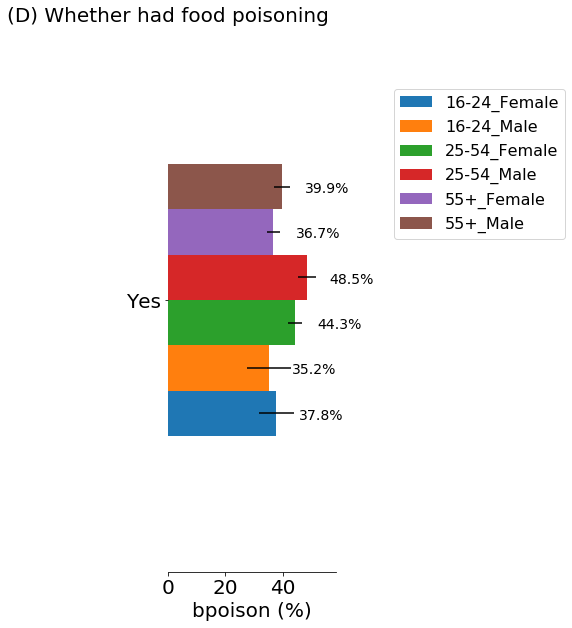

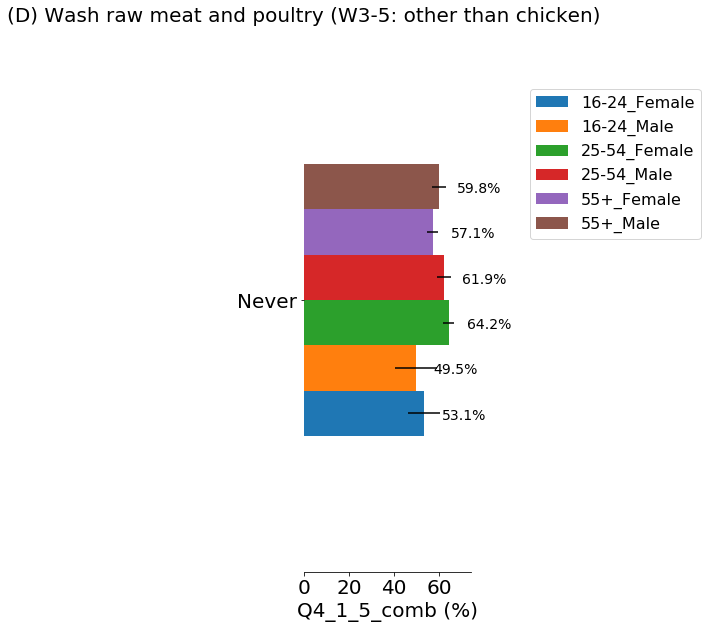

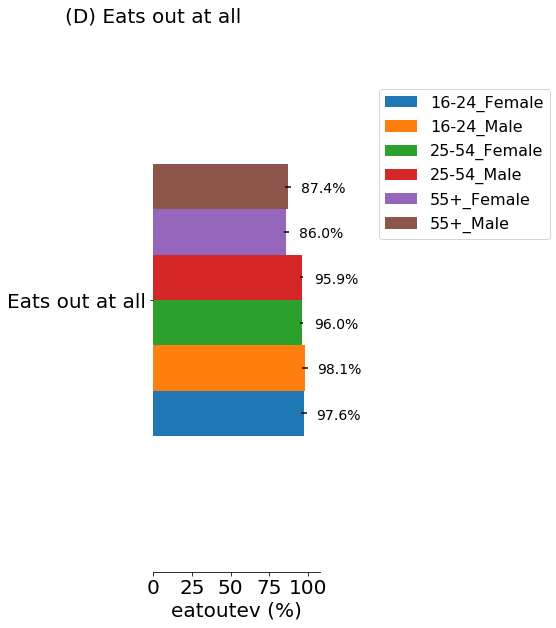

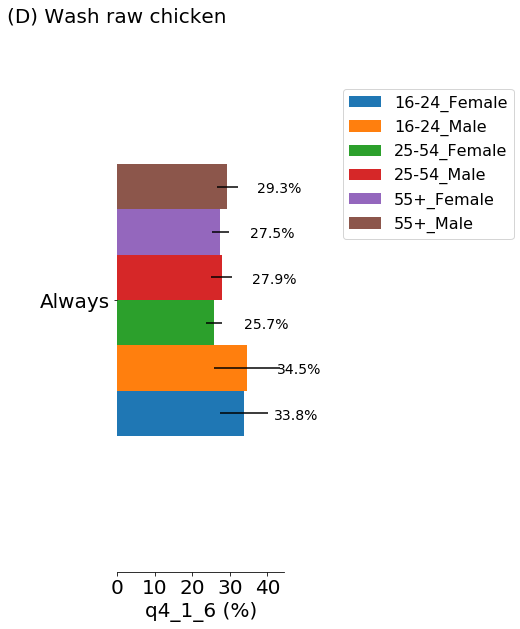

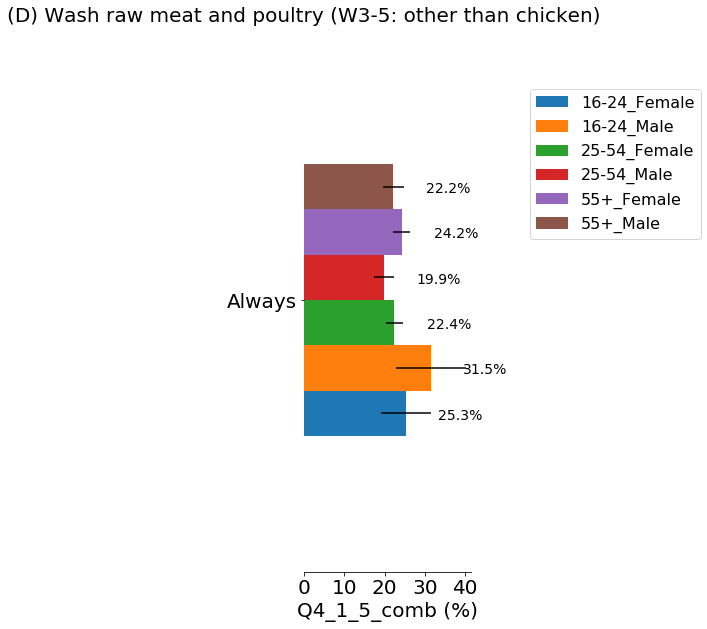

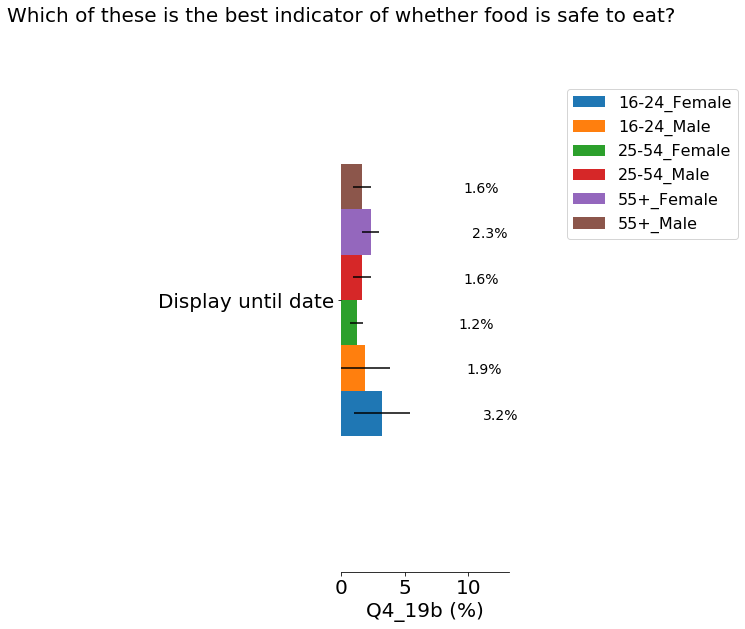

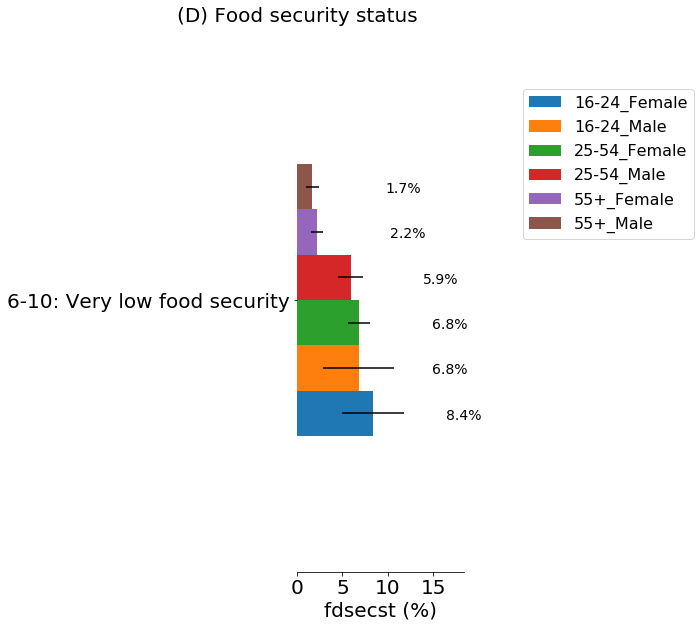

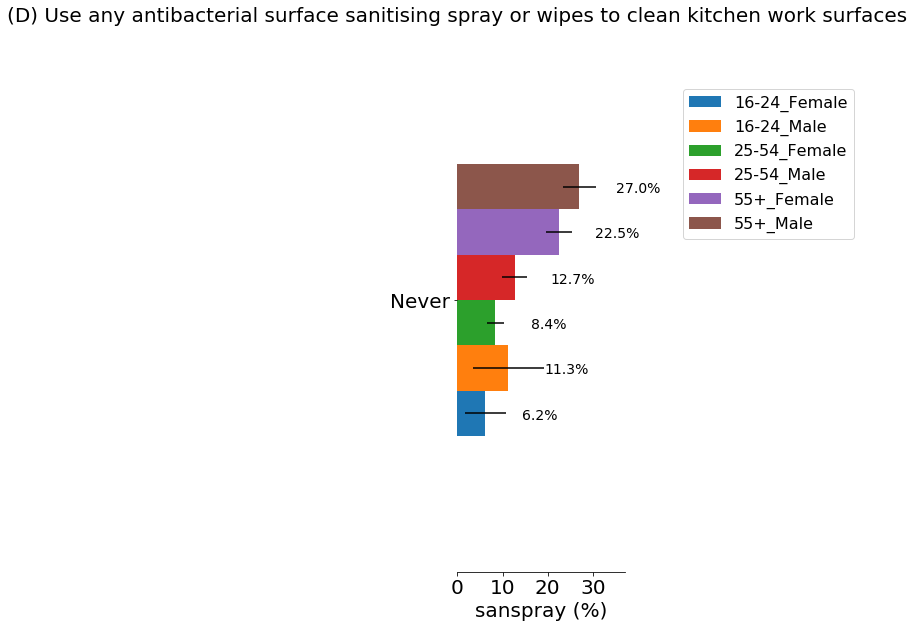

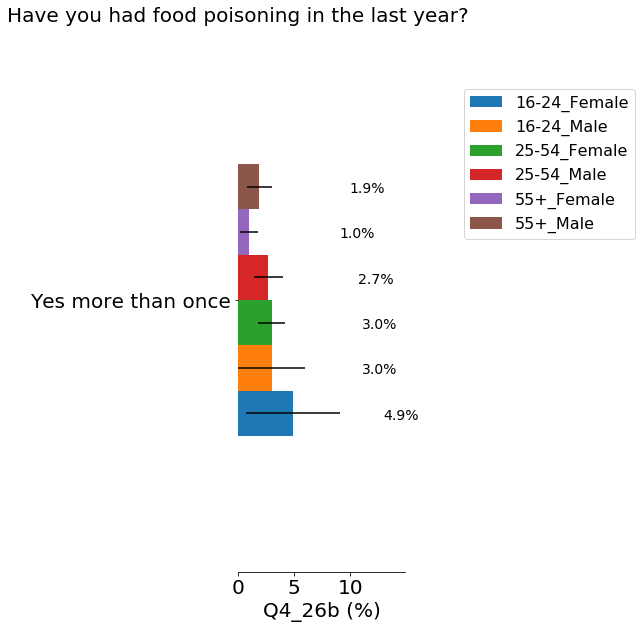

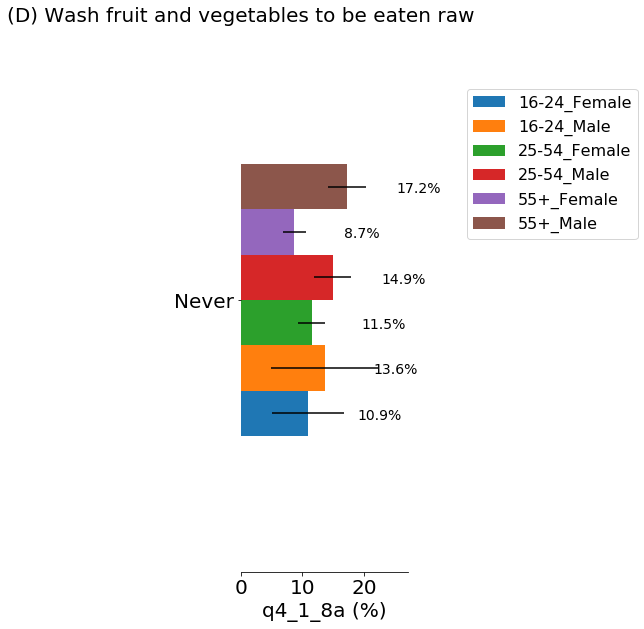

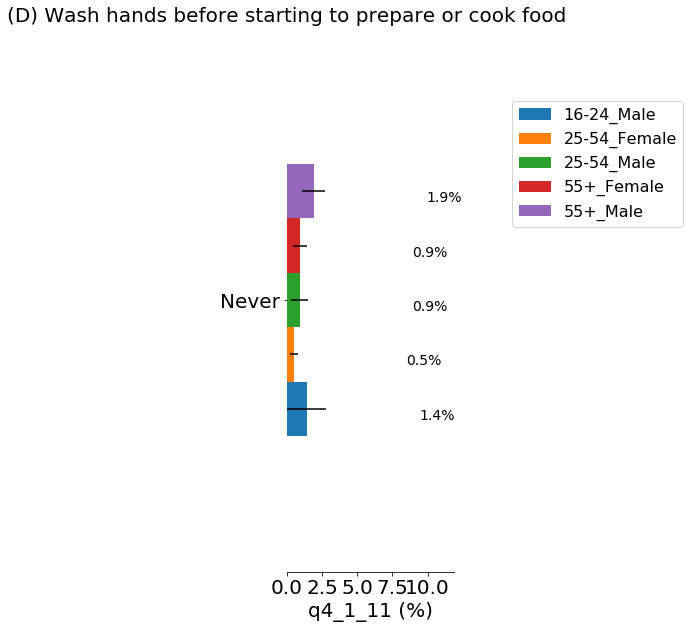

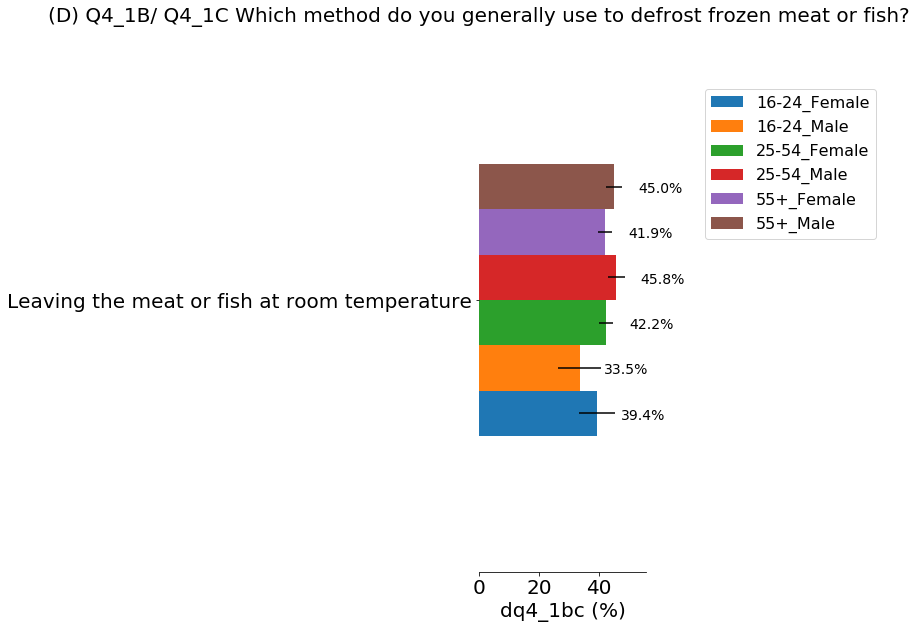

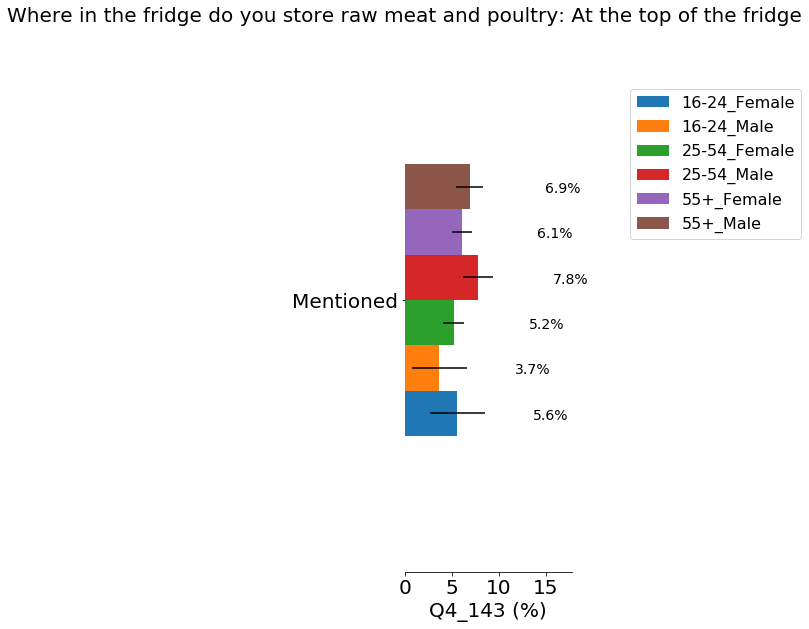

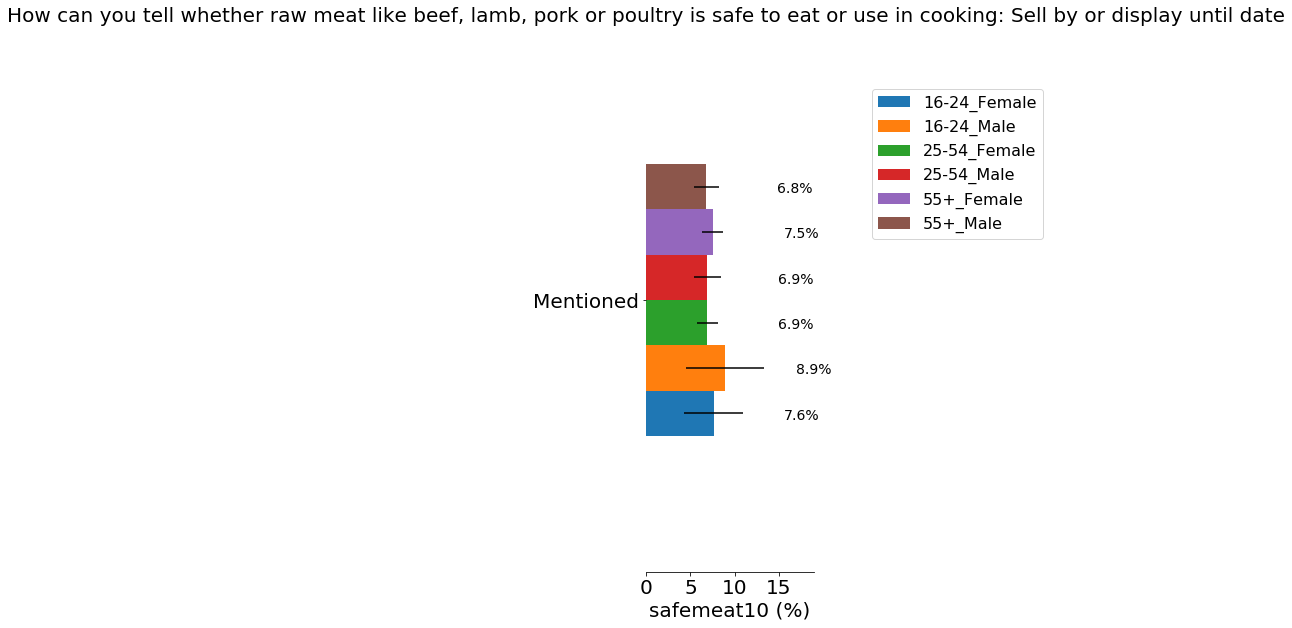

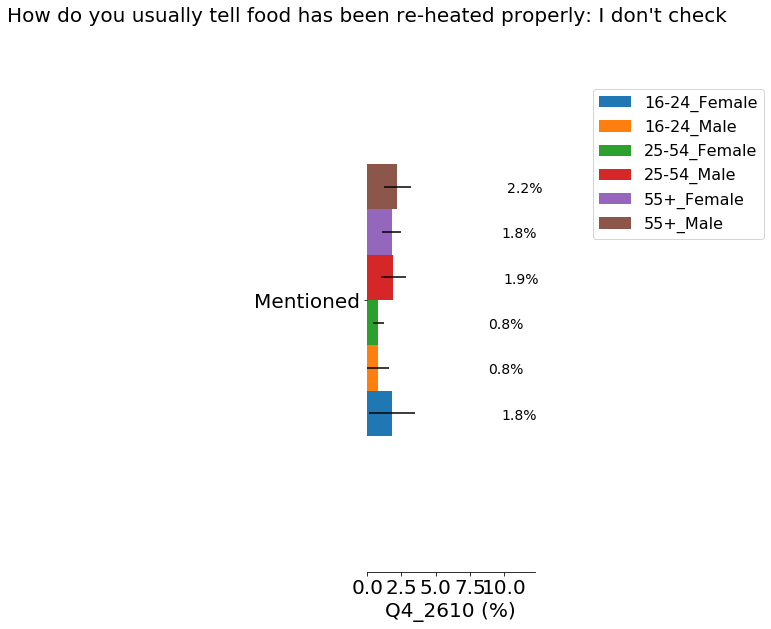

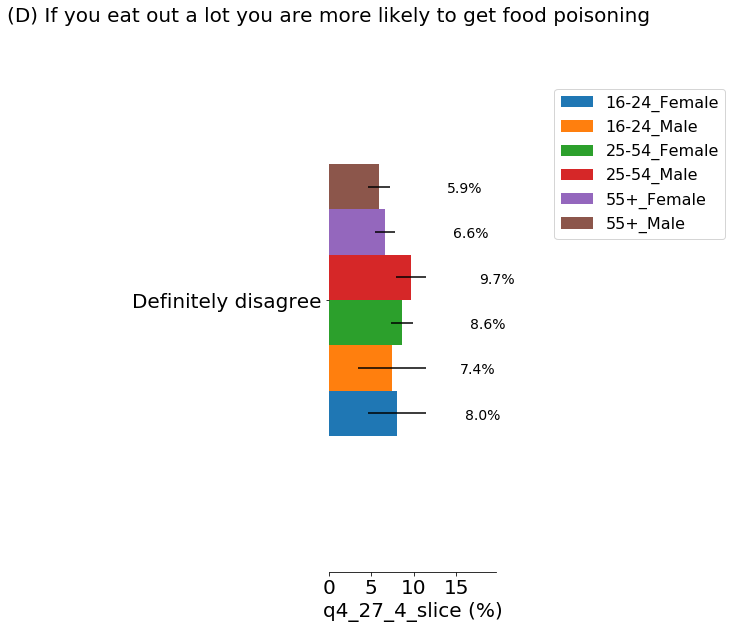

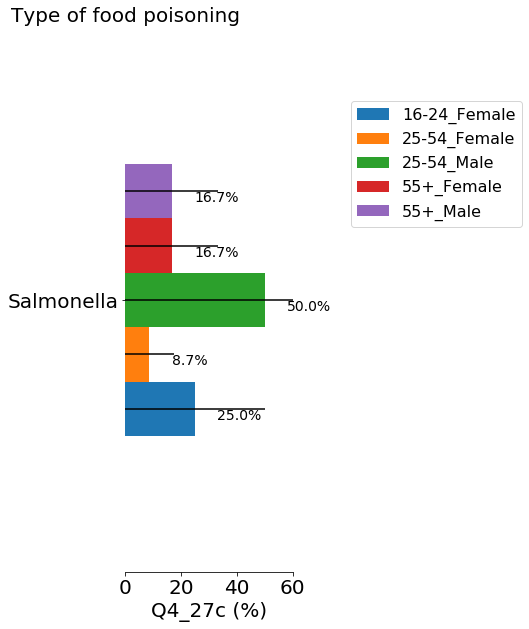

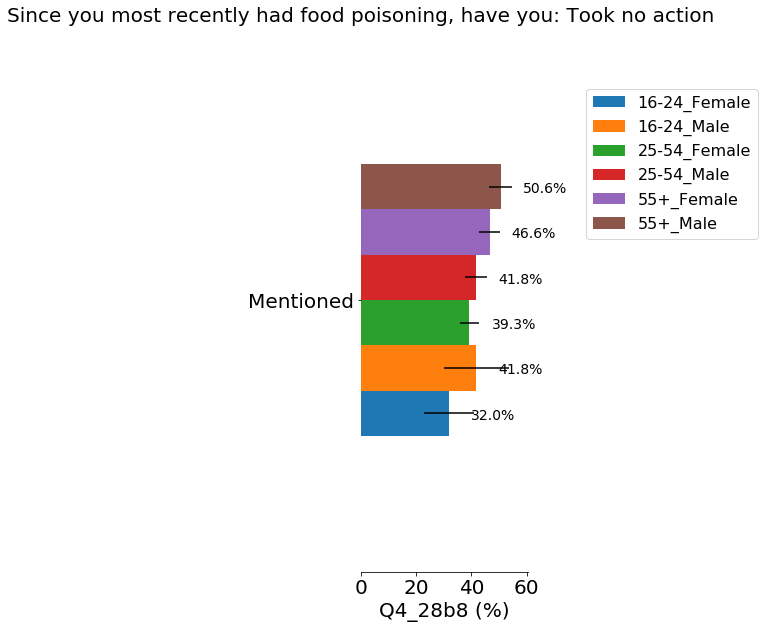

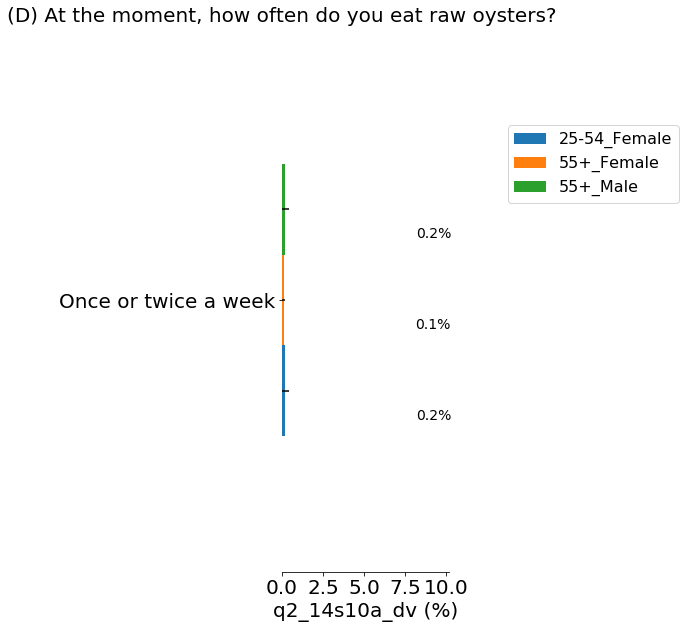

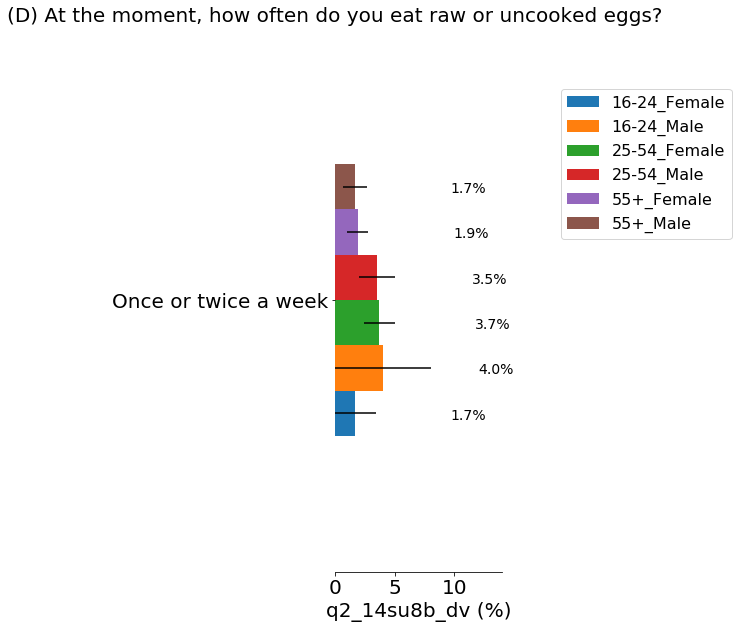

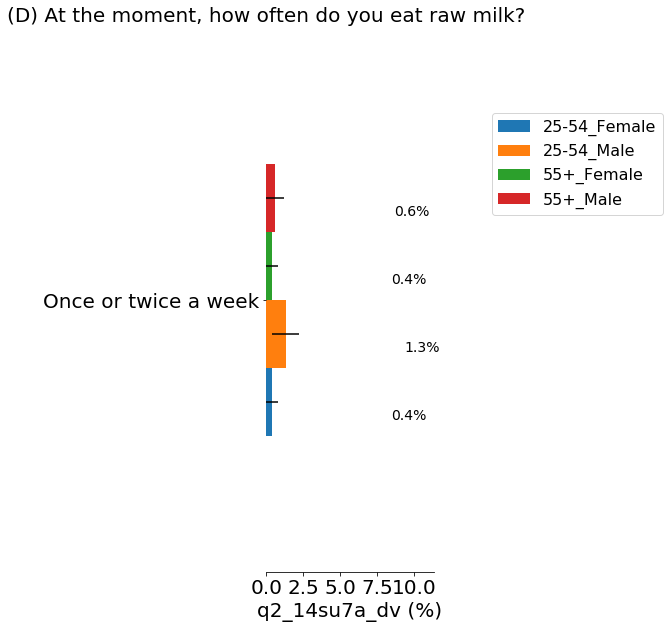

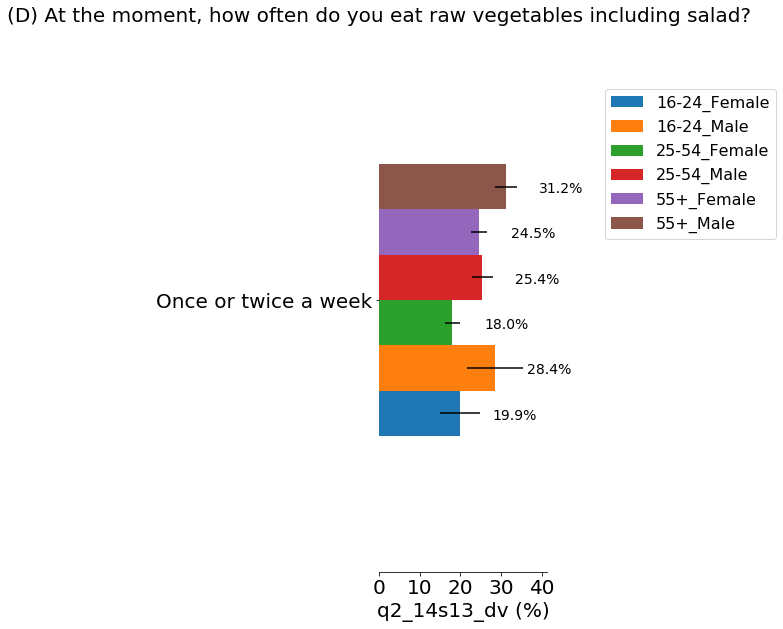

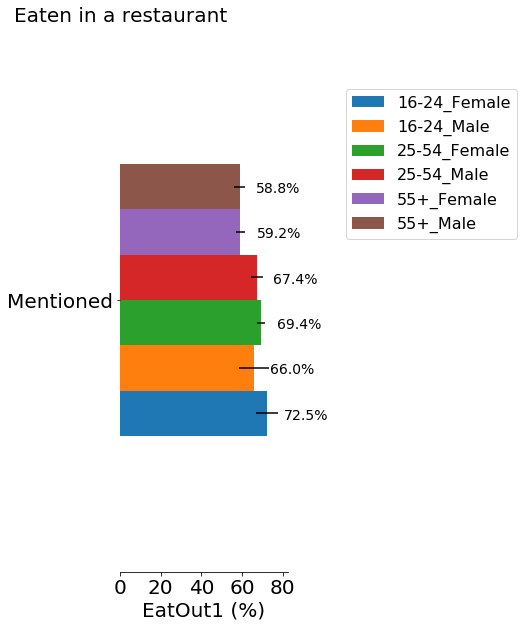

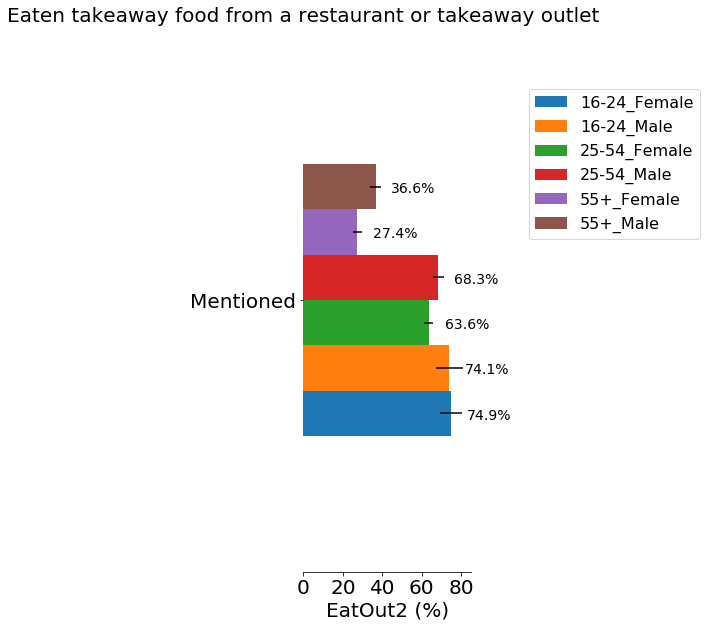

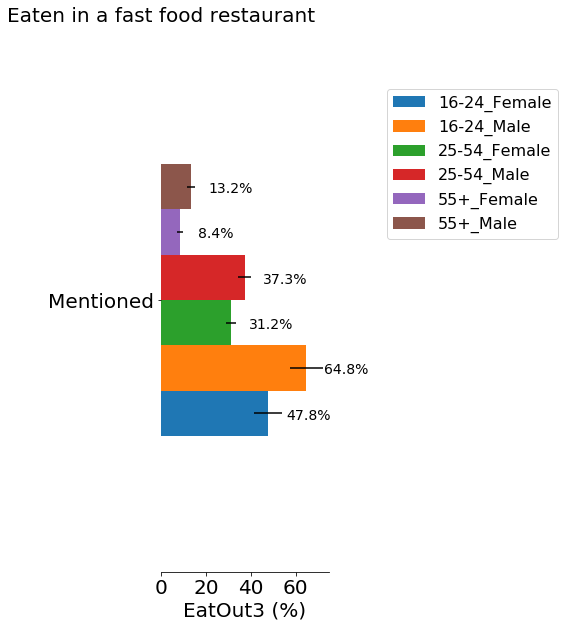

In [213]:
# Plot food risks associated to desired subpopulation groups for specified relevant questions:
# Only high risk answers plotted

custom_barplots(survey_subpopulation,
                'combined_demographics',
                questions_of_interest,
                'foodBehaviour_highRisk_byDemographics.pdf',
                myspacingy=0.03, myspacingx=8, myfontsize=14,
                high_risk_option='yes')

In [348]:
# Set up for the interactive dashboard inside notebook:

# Plot food risks associated to desired subpopulation groups for specified relevant questions:

country_dict = answers_dict['country_dv']
country_list = list(survey_subpopulation.country_dv.unique())
country_list[:] = [country_dict.get(e,'') for e in country_list]
country_dict_inv = {v: k for k, v in country_dict.items()}

region_dict = answers_dict['region_dv']
region_list = list(survey_subpopulation.region_dv.unique())
region_list[:] = [region_dict.get(e,'') for e in region_list]
region_dict_inv = {v: k for k, v in region_dict.items()}

questions_of_interest_names = questions_of_interest.copy()
questions_of_interest_names[:] = [questions_dict.get(e,'') for e in questions_of_interest_names]
questions_dict_inv = {v: k for k, v in questions_dict.items()}

risks_options = ['No', 'Yes']

demographics_list = ['Not applicable', 'Age (in detail)', 'Age', 'Gender', 'Marital status', 'Working status',
                     'Religion', 'Health', 'Urban-Rural classification', 'Household size',
                     'Household income', 'Children under 6 in household', 'Children under 16 in household']

demographic_dict = {'Not applicable':'dummy', 'Age (in detail)':'age_dv', 'Age':'age_dv_grouped', 'Gender':'RespSex',
                    'Marital status':'marstat2', 'Working status':'workstat2', 'Religion':'religion_dv',
                    'Health':'Q6_1', 'Urban-Rural classification':'UrbanRuralInd',
                    'Household size':'bhhsize2', 'Household income':'hhdinc',
                    'Children under 6 in household':'below6', 'Children under 16 in household':'below16'}

In [349]:
# Whole UK

@interact
def plot(question=questions_of_interest_names,
         risk_only=risks_options,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    
    if risk_only == 'No':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)])        
        custom_barplots(survey_subpopulation,
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        interactivity='yes', barwidth=0.9)
        
    if risk_only == 'Yes':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)]) 
        custom_barplots(survey_subpopulation,
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        high_risk_option='yes', interactivity='yes', barwidth=0.9) 

interactive(children=(Dropdown(description='question', options=('(D) Whether had food poisoning', '(D) Wash ra…

In [350]:
# Per country

@interact
def plot(country=country_list,
         question=questions_of_interest_names,
         risk_only=risks_options,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    
    if risk_only == 'No':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)])        
        custom_barplots(survey_subpopulation[survey_subpopulation.country_dv.eq(country_dict_inv.get(country))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        interactivity='yes', barwidth=0.9)
        
    if risk_only == 'Yes':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)]) 
        custom_barplots(survey_subpopulation[survey_subpopulation.country_dv.eq(country_dict_inv.get(country))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        high_risk_option='yes', interactivity='yes', barwidth=0.9) 

interactive(children=(Dropdown(description='country', options=('England', 'Wales', 'Northern Ireland'), value=…

In [351]:
# Per region

@interact
def plot(region=region_list,
         question=questions_of_interest_names,
         risk_only=risks_options,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    
    if risk_only == 'No':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)])        
        custom_barplots(survey_subpopulation[survey_subpopulation.region_dv.eq(region_dict_inv.get(region))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        interactivity='yes', barwidth=0.9)
        
    if risk_only == 'Yes':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)]) 
        custom_barplots(survey_subpopulation[survey_subpopulation.region_dv.eq(region_dict_inv.get(region))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        high_risk_option='yes', interactivity='yes', barwidth=0.9) 

interactive(children=(Dropdown(description='region', options=('South West', 'South East', 'Wales', 'Yorkshire …

In [ ]:
# Interactive dashboard outside notebook:

# To show this as an independent (local) dashboard with Voila (https://github.com/voila-dashboards/voila):
# Install in terminal by: conda install -c conda-forge voila
# Start Voilà locally (cd in directory with this notebook) by running: voila Food-and-You-survey_risks.ipynb

# To give access to voila dashboard remotely using github and binder:
# Set up a public github repo with all data files needed (as csv),
# jupyter notebook with widgets(in which all csv files are read using the raw URLs from github)
# and a requirements.txt (listing  all the modules needed to run the notebook).
# Use binder (https://mybinder.org) and specify the path of the jupypter notebook (using voila/render),
# indicate it is a URL path.
# The new URL generated can be shared and is available any time.

# To give access to voila dashboard remotely using ngrok:
# (see https://voila.readthedocs.io/en/stable/deploy.html#sharing-voila-applications-with-ngrok)
# Install ngrok: https://ngrok.com/download, unzip file and, if using macOS, move executable file to /usr/local/bin
# Start Voilà locally (cd in directory with this notebook) by running: voila Food-and-You-survey_risks.ipynb
# In a new terminal window, start ngrok by running: ngrok http 8866 (check local host number actually used by
# the dashboard of interest, as, if running voila multiple times, this number will change)
# Copy the link from the ngrok terminal window (link looks like https://8bb6fded.ngrok.io) and use or send link.
# Website will take some time to load, as the jupyter noteook is running in the background.
# When using the ngrok link, the requests will be forwared to your local instance of Voilà.

# Census data is too heavy and cannot be ploted as a voila dashboard